In [1189]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

from datetime import datetime
import matplotlib.pyplot as plt
from math import ceil
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from pandas_profiling import ProfileReport

In [1190]:
df = pd.read_sas('a2z_insurance.sas7bdat')
df.set_index('CustID', inplace=True)

In [1191]:
df.head(5)

FirstPolYear  BirthYear             EducDeg  MonthSal  GeoLivArea  \
CustID                                                                      
1.0           1985.0     1982.0  b'2 - High School'    2177.0         1.0   
2.0           1981.0     1995.0  b'2 - High School'     677.0         4.0   
3.0           1991.0     1970.0        b'1 - Basic'    2277.0         3.0   
4.0           1990.0     1981.0      b'3 - BSc/MSc'    1099.0         4.0   
5.0           1986.0     1973.0      b'3 - BSc/MSc'    1763.0         4.0   

        Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  \
CustID                                                               
1.0          1.0      380.97        0.39     375.85          79.45   
2.0          1.0     -131.13        1.12      77.46         416.20   
3.0          0.0      504.67        0.28     206.15         224.50   
4.0          1.0      -16.99        0.99     182.48          43.35   
5.0          1.0       35.23        0.90     338.62          47.80   

        PremHealth  PremLife  PremWork  
CustID                                  
1.0         146.36     47.01     16.89  
2.0         116.69    194.48    106.13  
3.0         124.58     86.35     99.02  
4.0         311.17     35.34     28.34  
5.0         182.59     18.78     41.45

In [1192]:
df.shape

(10296, 13)

In [1193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 10296 entries, 1.0 to 10296.0
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   FirstPolYear   10266 non-null  float64
 1   BirthYear      10279 non-null  float64
 2   EducDeg        10279 non-null  object 
 3   MonthSal       10260 non-null  float64
 4   GeoLivArea     10295 non-null  float64
 5   Children       10275 non-null  float64
 6   CustMonVal     10296 non-null  float64
 7   ClaimsRate     10296 non-null  float64
 8   PremMotor      10262 non-null  float64
 9   PremHousehold  10296 non-null  float64
 10  PremHealth     10253 non-null  float64
 11  PremLife       10192 non-null  float64
 12  PremWork       10210 non-null  float64
dtypes: float64(12), object(1)
memory usage: 1.1+ MB


In [1194]:
non_metric_features = ["EducDeg", "Children", 'GeoLivArea']
metric_features=df.columns.drop(non_metric_features).to_list()

In [1195]:
df_info = pd.DataFrame(columns={"column", "NaN", "NaN %"})
for index, value in df.isna().sum().iteritems():
    df_temp = pd.DataFrame({"column" : index, "NaN" : [value], "NaN %" : round(value*100 /len(df), 2)})
    df_info = pd.concat([df_info, df_temp], ignore_index=True)
    df_info.sort_values(by="NaN", ascending=False, inplace=True)

print(df_info)

    NaN NaN %         column
0   104  1.01       PremLife
12   86  0.84       PremWork
1    43  0.42     PremHealth
2    36  0.35       MonthSal
3    34  0.33      PremMotor
4    30  0.29   FirstPolYear
5    21   0.2       Children
6    17  0.17      BirthYear
7    17  0.17        EducDeg
8     1  0.01     GeoLivArea
9     0   0.0     CustMonVal
10    0   0.0     ClaimsRate
11    0   0.0  PremHousehold


### %%%% explicar que como nenhuma coluna tem mais de 3% de Nans, não eliminamos os nans, vamos imputar

In [1196]:
#Check duplicates
df.duplicated().sum()

3

In [1197]:
df.drop_duplicates(inplace=True)

In [1198]:
#Check duplicates
df.duplicated().sum()

0

# Fill Nans
### This data doesn't have a lot of missing values, but we will fill them with 4 different approaches and then test it when doing clusters
#### For each approach we are going to plot a range of data (using the metric with more missing values VS another metric), so that it is possible to identify the missing values ​​filled in. Since if we showed all the data, it would be impossible to see them graphically
#### All filled missing values are going to be plotted in red color

### - Using mode for both metric and non metric:

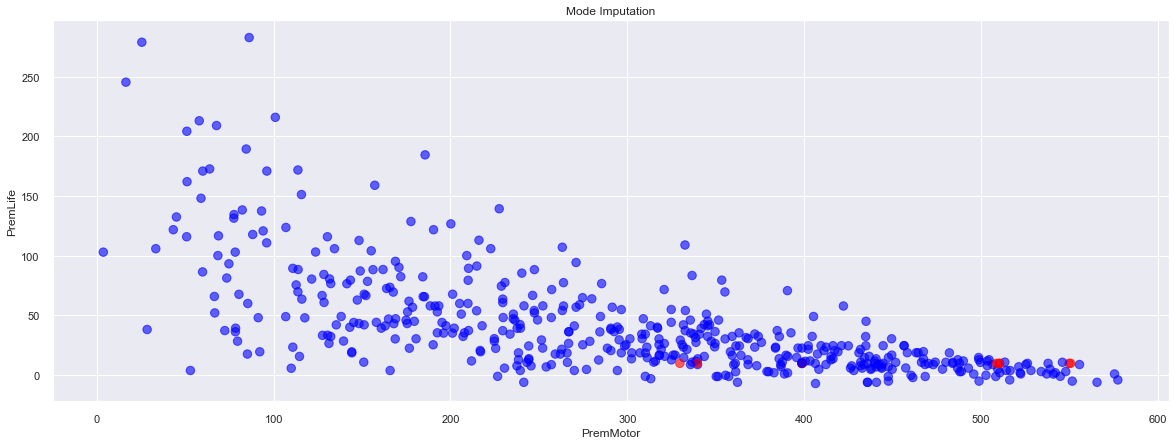

In [1199]:
# Mode Imputation

df_mode = df.copy()
mode_imputer = SimpleImputer(strategy='most_frequent')
df_mode[metric_features] = mode_imputer.fit_transform(df_mode[metric_features].values)
df_mode[non_metric_features] = mode_imputer.fit_transform(df_mode[non_metric_features].values)

# Scatter plot

fig = plt.Figure()
null_values = df['PremLife'].isnull()
fig = df_mode[4020:4502].plot(x='PremMotor', y='PremLife', kind='scatter', c=null_values[4020:4502], cmap='bwr', title='Mode Imputation', colorbar=False, alpha=0.6, figsize=(20,7), s=72)


### - Using mean for metric and mode for non metric:

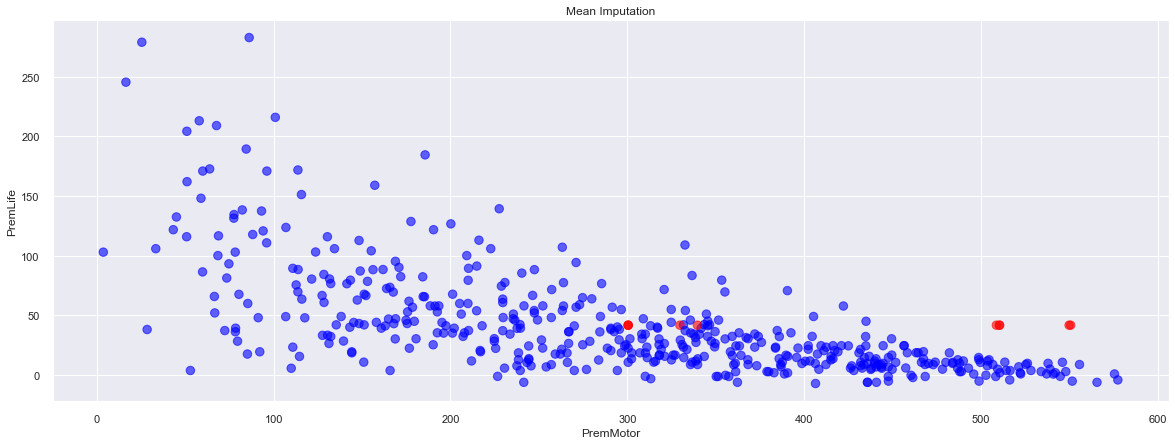

In [1200]:
# Mean Imputation

df_mean = df.copy()
mean_imputer = SimpleImputer(strategy='mean')
df_mean[metric_features] = mean_imputer.fit_transform(df_mean[metric_features].values)
df_mean[non_metric_features] = mode_imputer.fit_transform(df_mean[non_metric_features].values)


# Scatter plot

fig = plt.Figure()
null_values = df['PremLife'].isnull()
fig = df_mean[4020:4502].plot(x='PremMotor', y='PremLife', kind='scatter', c=null_values[4020:4502], cmap='bwr', title='Mean Imputation', colorbar=False, alpha=0.6, figsize=(20,7), s=72)



### - Using KNN Imputer for both metric and non metric:

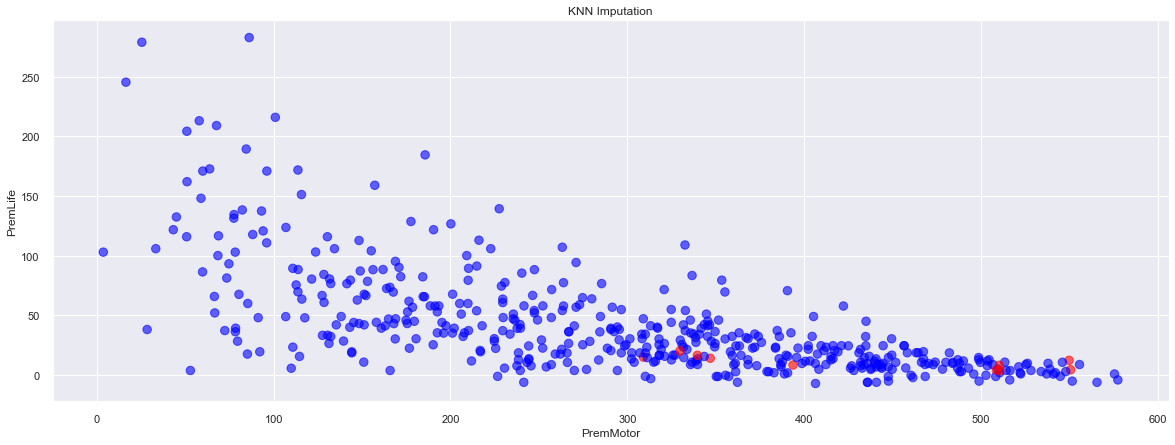

In [1201]:
df_kmeans=df.copy()

le=LabelEncoder()

imputer = KNNImputer(n_neighbors=5, weights="uniform")
df_kmeans[metric_features] = imputer.fit_transform(df_kmeans[metric_features])

dict_educdeg = {b'3 - BSc/MSc' : 3,  b'2 - High School' : 2, b'1 - Basic': 1 , b'4 - PhD': 4}
df_kmeans.replace({"EducDeg": dict_educdeg}, inplace=True)

# df_kmeans['EducDeg']=df_kmeans['EducDeg'].astype(int)

df_kmeans[non_metric_features] = imputer.fit_transform(df_kmeans[non_metric_features])

#round new values to one of the labels
df_kmeans['EducDeg']=df_kmeans['EducDeg'].round(0)
df_kmeans['Children']=df_kmeans['Children'].round(0)
df_kmeans['GeoLivArea']=df_kmeans['GeoLivArea'].round(0)


dict_educdeg = {3 : b'3 - BSc/MSc', 2: b'2 - High School',1 :  b'1 - Basic' , 4 : b'4 - PhD'}
df_kmeans.replace({"EducDeg": dict_educdeg}, inplace=True)


# Scatter plot

fig = plt.Figure()
null_values = df['PremLife'].isnull()
fig = df_kmeans[4020:4502].plot(x='PremMotor', y='PremLife', kind='scatter', c=null_values[4020:4502], cmap='bwr', title='KNN Imputation', colorbar=False, alpha=0.6, figsize=(20,7), s=72)


### - Using linear interpolation for both metric and non metric:

<AxesSubplot:title={'center':'PremLife'}, xlabel='CustID'>

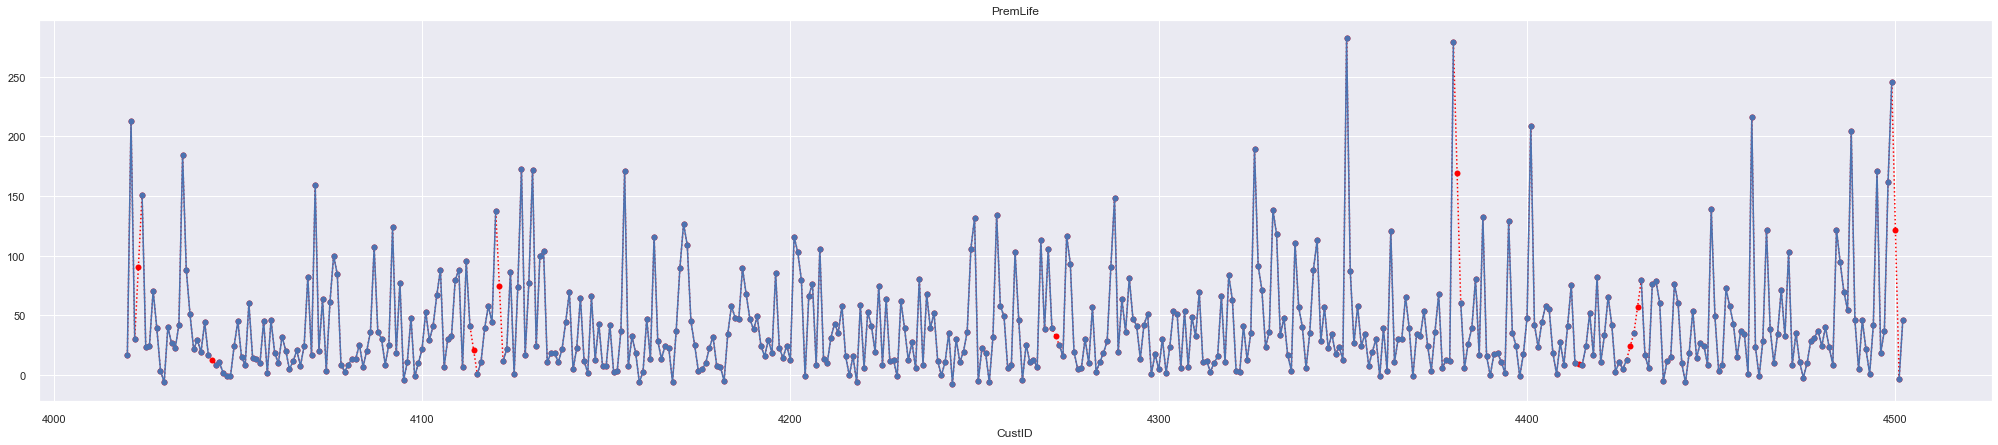

In [1202]:
df_interpolation=df.copy()
# Imputing with linear interpolation
linear_interpolation = df_interpolation.interpolate(method='linear')

# Plot imputed data

linear_interpolation['PremLife'][4020:4502].plot(color='red', marker='o', linestyle='dotted')
df_interpolation['PremLife'][4020:4502].plot(title='PremLife', marker='o', figsize=(35,7))

In [1203]:
df_filled=df_kmeans.copy()

In [1204]:
#convert some variables to int
df_filled = df_filled.astype({'FirstPolYear': int, 'BirthYear': int, 'MonthSal': int , 'GeoLivArea': int, 'Children': int})
#convert index to int
df_filled.index = df_filled.index.astype(int)

In [1205]:
df_filled.sample(5)

FirstPolYear  BirthYear             EducDeg  MonthSal  GeoLivArea  \
CustID                                                                      
5663            1987       1964      b'3 - BSc/MSc'      2720           1   
7810            1990       1989  b'2 - High School'      1754           3   
6579            1983       1972  b'2 - High School'      2173           1   
7074            1977       1968      b'3 - BSc/MSc'      2006           4   
2964            1978       1986        b'1 - Basic'      1662           3   

        Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  \
CustID                                                               
5663           1       93.57        0.81     297.39          64.45   
7810           1      346.06        0.47     242.60         133.35   
6579           1       34.79        0.90     249.38          40.00   
7074           1      -25.00        1.00     402.52          53.90   
2964           1     -108.35        1.10     153.25         343.40   

        PremHealth  PremLife  PremWork  
CustID                                  
5663        174.70     24.45     78.57  
7810        281.72     40.12      4.89  
6579        213.04     59.79     52.79  
7074        158.14     14.78     21.78  
2964        204.15     76.57     83.35

In [1206]:
#Check if Nans were all filled
df_filled.isna().sum()

FirstPolYear     0
BirthYear        0
EducDeg          0
MonthSal         0
GeoLivArea       0
Children         0
CustMonVal       0
ClaimsRate       0
PremMotor        0
PremHousehold    0
PremHealth       0
PremLife         0
PremWork         0
dtype: int64

In [1207]:
# print columns with Nans
nans_index = df.isna().any(axis=1)
df[nans_index]

FirstPolYear  BirthYear             EducDeg  MonthSal  GeoLivArea  \
CustID                                                                       
22.0           1977.0     1958.0  b'2 - High School'       NaN         3.0   
69.0           1983.0     1977.0  b'2 - High School'    1399.0         4.0   
139.0          1979.0     1976.0  b'2 - High School'    2538.0         2.0   
144.0          1996.0     1990.0      b'3 - BSc/MSc'       NaN         4.0   
185.0          1993.0     1984.0  b'2 - High School'    2419.0         4.0   
...               ...        ...                 ...       ...         ...   
10011.0           NaN     1947.0  b'2 - High School'    3959.0         2.0   
10058.0        1983.0     1980.0  b'2 - High School'    1569.0         4.0   
10143.0        1986.0     1985.0      b'3 - BSc/MSc'    1652.0         3.0   
10285.0        1980.0     1987.0      b'3 - BSc/MSc'    1504.0         4.0   
10286.0        1985.0     1948.0      b'3 - BSc/MSc'    3878.0         4.0   

         Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  \
CustID                                                                
22.0          1.0      111.37        0.80     407.52         111.70   
69.0          1.0      476.65        0.33     330.73         186.70   
139.0         1.0      149.59        0.69     194.26         305.60   
144.0         1.0      -42.45        1.02     146.36         353.95   
185.0         1.0      -62.23        1.07        NaN         253.95   
...           ...         ...         ...        ...            ...   
10011.0       NaN     -128.24        1.14     177.81         153.35   
10058.0       1.0      222.60        0.55     235.60         211.15   
10143.0       1.0       55.67        0.88     257.05          94.45   
10285.0       1.0       -1.55        0.96     390.63          29.45   
10286.0       1.0      -57.45        1.04     269.05         217.25   

         PremHealth  PremLife  PremWork  
CustID                                   
22.0         100.13     24.67     30.34  
69.0         211.15       NaN     15.78  
139.0           NaN     37.34     17.67  
144.0        220.04    121.80     42.01  
185.0        230.60      5.89     43.12  
...             ...       ...       ...  
10011.0      311.28     67.79     35.45  
10058.0         NaN     32.34     68.79  
10143.0      308.39       NaN     13.78  
10285.0      179.70     -6.00       NaN  
10286.0      219.93     32.45       NaN  

[309 rows x 13 columns]

In [1208]:
#print the same columns with Nans filled
df_filled[nans_index]

FirstPolYear  BirthYear             EducDeg  MonthSal  GeoLivArea  \
CustID                                                                      
22              1977       1958  b'2 - High School'      2541           3   
69              1983       1977  b'2 - High School'      1399           4   
139             1979       1976  b'2 - High School'      2538           2   
144             1996       1990      b'3 - BSc/MSc'      1721           4   
185             1993       1984  b'2 - High School'      2419           4   
...              ...        ...                 ...       ...         ...   
10011           1990       1947  b'2 - High School'      3959           2   
10058           1983       1980  b'2 - High School'      1569           4   
10143           1986       1985      b'3 - BSc/MSc'      1652           3   
10285           1980       1987      b'3 - BSc/MSc'      1504           4   
10286           1985       1948      b'3 - BSc/MSc'      3878           4   

        Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  \
CustID                                                               
22             1      111.37        0.80    407.520         111.70   
69             1      476.65        0.33    330.730         186.70   
139            1      149.59        0.69    194.260         305.60   
144            1      -42.45        1.02    146.360         353.95   
185            1      -62.23        1.07    264.428         253.95   
...          ...         ...         ...        ...            ...   
10011          1     -128.24        1.14    177.810         153.35   
10058          1      222.60        0.55    235.600         211.15   
10143          1       55.67        0.88    257.050          94.45   
10285          1       -1.55        0.96    390.630          29.45   
10286          1      -57.45        1.04    269.050         217.25   

        PremHealth  PremLife  PremWork  
CustID                                  
22         100.130    24.670    30.340  
69         211.150    33.784    15.780  
139        226.598    37.340    17.670  
144        220.040   121.800    42.010  
185        230.600     5.890    43.120  
...            ...       ...       ...  
10011      311.280    67.790    35.450  
10058      247.602    32.340    68.790  
10143      308.390    23.338    13.780  
10285      179.700    -6.000    15.736  
10286      219.930    32.450    41.830  

[309 rows x 13 columns]

In [1209]:
#copy to df
df=df_filled.copy()

In [1210]:
#convert birth year to age
df['Age'] = 2016-df['BirthYear']
df.drop(columns='BirthYear', inplace=True)

#remove from metric_features list
metric_features.remove('BirthYear')

#add age to metric_features list
metric_features.append('Age')

In [1211]:
# print of unique values to check coherence
for col in df[non_metric_features]:
    print('\033[1;3mUnique values of "' + col + '"\033[0m ')
    print(df[col].unique())
    print('\n')

Unique values of "EducDeg" 
[b'2 - High School' b'1 - Basic' b'3 - BSc/MSc' b'4 - PhD']


Unique values of "Children" 
[1 0]


Unique values of "GeoLivArea" 
[1 4 3 2]




<AxesSubplot:xlabel='GeoLivArea', ylabel='count'>

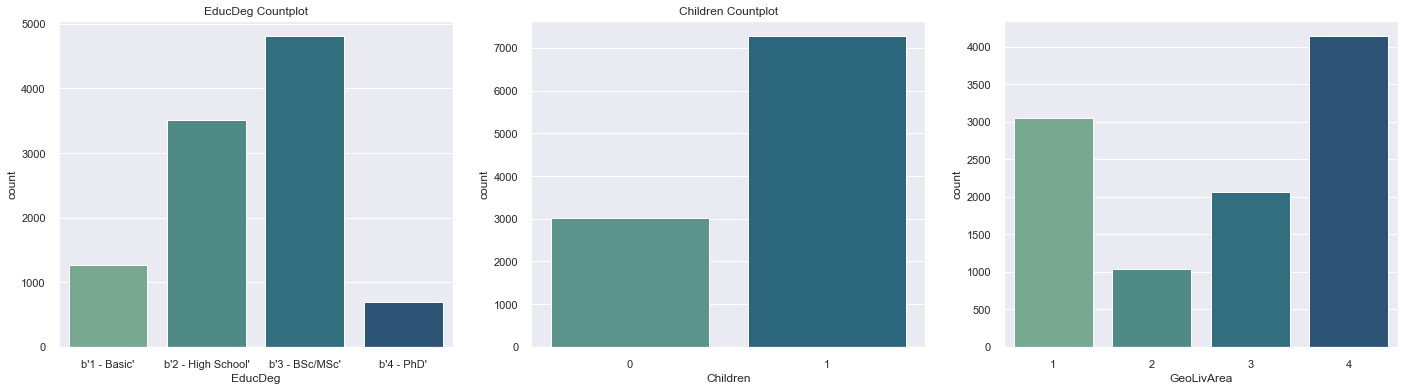

In [1212]:
fig, ax = plt.subplots(1,3, figsize=(24,6))
ax[0].title.set_text('EducDeg Countplot')
ax[1].title.set_text('Children Countplot')
sns.countplot(data=df, x="EducDeg", ax=ax[0], palette='crest', order=df.EducDeg.value_counts().index.sort_values(), dodge=False)
sns.countplot(data=df, x="Children", ax=ax[1], palette='crest',  dodge=False)
sns.countplot(data=df, x="GeoLivArea", ax=ax[2], palette='crest',  dodge=False)


In [1213]:
df.describe(include='all').T

count unique             top  freq         mean          std  \
FirstPolYear   10293.0    NaN             NaN   NaN  1991.049062   510.596931   
EducDeg          10293      4  b'3 - BSc/MSc'  4808          NaN          NaN   
MonthSal       10293.0    NaN             NaN   NaN   2506.40921  1156.183192   
GeoLivArea     10293.0    NaN             NaN   NaN     2.709414     1.266241   
Children       10293.0    NaN             NaN   NaN     0.706597     0.455344   
CustMonVal     10293.0    NaN             NaN   NaN   177.929963  1946.091554   
ClaimsRate     10293.0    NaN             NaN   NaN     0.742728     2.917385   
PremMotor      10293.0    NaN             NaN   NaN   300.702459    211.67798   
PremHousehold  10293.0    NaN             NaN   NaN   210.419863   352.635041   
PremHealth     10293.0    NaN             NaN   NaN   171.596339   295.845039   
PremLife       10293.0    NaN             NaN   NaN    41.616451    47.353344   
PremWork       10293.0    NaN             NaN   NaN    41.155432    51.381233   
Age            10293.0    NaN             NaN   NaN    47.994365     19.70243   

                     min     25%     50%     75%       max  
FirstPolYear      1974.0  1980.0  1986.0  1992.0   53784.0  
EducDeg              NaN     NaN     NaN     NaN       NaN  
MonthSal           333.0  1706.0  2501.0  3290.0   55215.0  
GeoLivArea           1.0     1.0     3.0     4.0       4.0  
Children             0.0     0.0     1.0     1.0       1.0  
CustMonVal    -165680.42   -9.44  187.03  399.86  11875.89  
ClaimsRate           0.0    0.39    0.72    0.98     256.2  
PremMotor          -4.11  191.26  299.28   408.3  11604.42  
PremHousehold      -75.0   49.45   132.8  290.05   25048.8  
PremHealth         -2.11  111.91  162.92  219.04   28272.0  
PremLife            -7.0    9.89   25.45   57.01     398.3  
PremWork           -12.0   10.67   25.67   56.12    1988.7  
Age                 15.0    33.0    48.0    63.0     988.0

### Analysis before outliers

In [1214]:
def box_plot_all_vars(data):
    # All Numeric Variables' Box Plots in one figure
    sns.set()

    # Prepare figure. Create individual axes where each box plot will be placed
    fig, axes = plt.subplots(4, ceil(len(metric_features) / 4), figsize=(25, 20))

    # Plot data
    # Iterate across axes objects and associate each box plot (hint: use the ax argument):
    for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
        bxplot = sns.boxplot(x=data[feat], ax=ax, color='chartreuse', fliersize=8)
        bxplot.set_xlabel(fontsize=16, xlabel=feat)

    
        
    # Layout
    # Add a centered title to the figure:
    title = "Numeric Variables' Box Plots"

    plt.suptitle(title, size=30)

    plt.show()

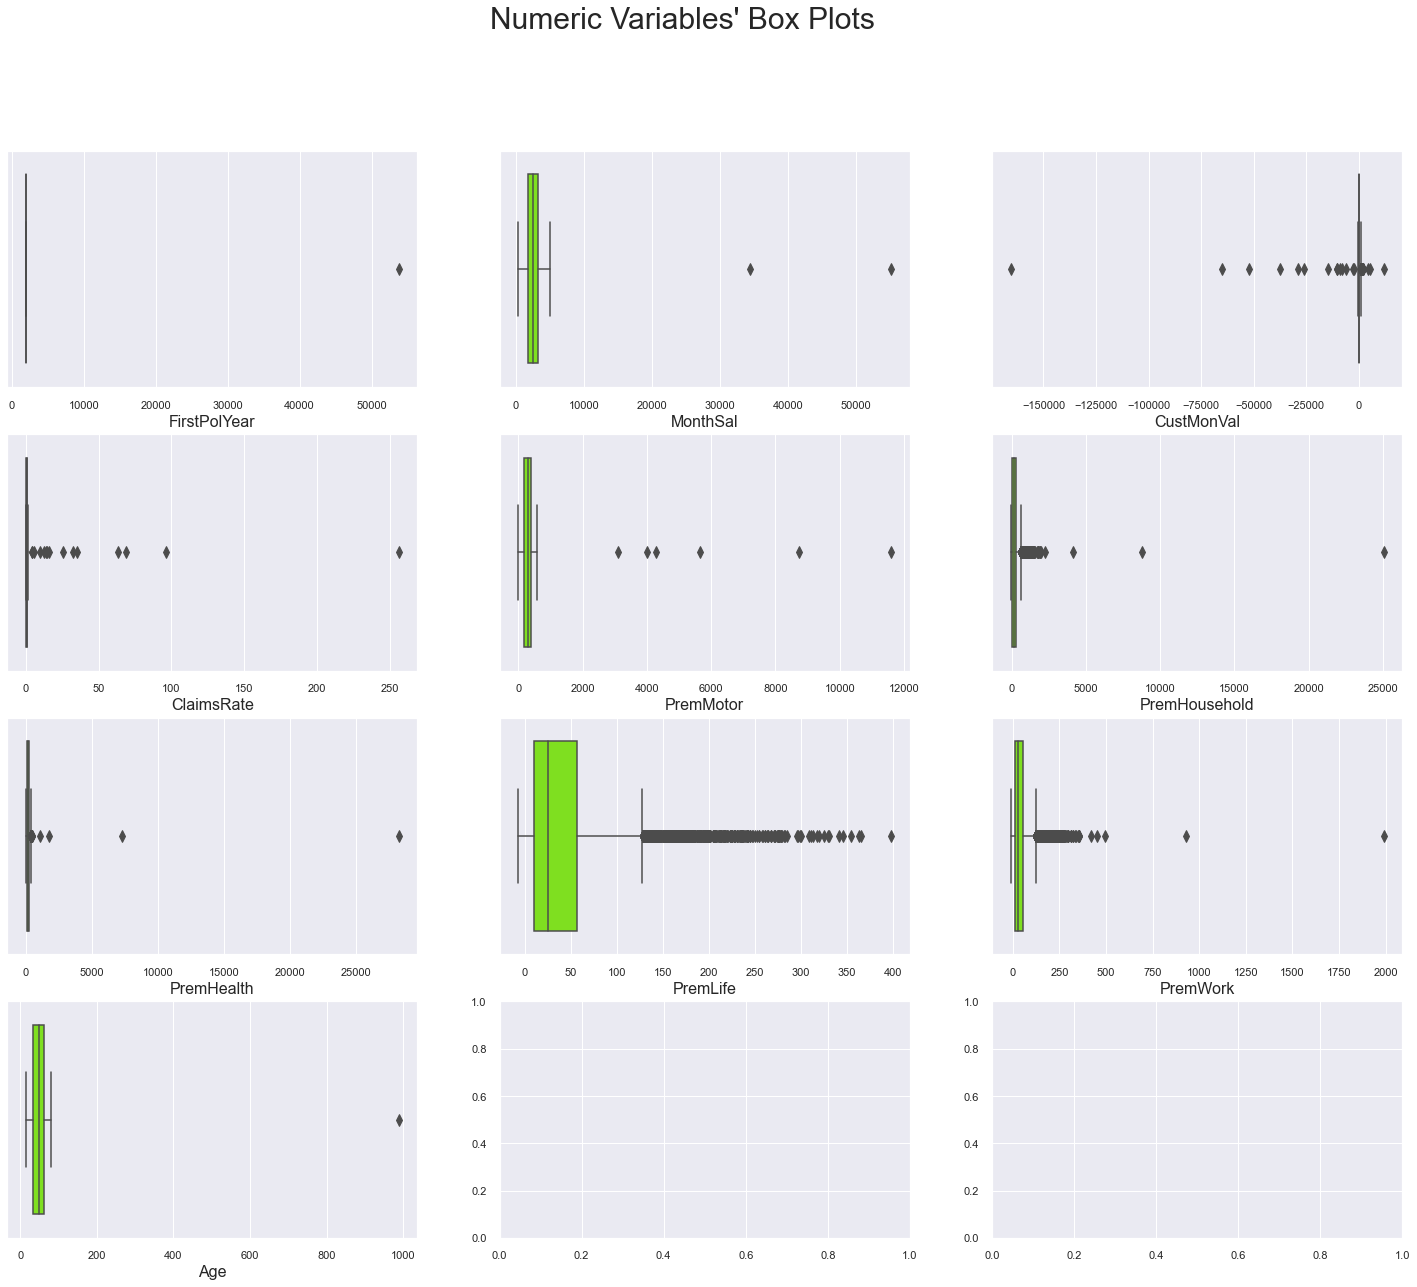

In [1215]:
box_plot_all_vars(df)

In [1216]:
##Following quartiles
filters1 = (
    (df['FirstPolYear']<=2016)
    &
    (df['MonthSal']<=5500)
    &
    (df['CustMonVal']>=-3000)
    &
    (df['CustMonVal']<=3000)
    &
    (df['ClaimsRate']<=6)
    &
    (df['PremMotor']<=700)
    &
    (df['PremHousehold']<=1500)
    &
    (df['PremHealth']<=760)
    &
    (df['PremLife']<=150)
    &
    (df['Age']<=85)
)

df_1 = df[filters1]
print('Percentage of data kept after removing outliers:', np.round(df_1.shape[0] / df.shape[0], 4))

Percentage of data kept after removing outliers: 0.9553


In [1217]:
# df_3['FirstPolYear'].unique()

In [1218]:
##IQR method
q25 = df.quantile(.25)
q75 = df.quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr

filters2 = []
for metric in metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters2.append(df[metric].between(llim, ulim, inclusive='both'))

filters2 = pd.Series(np.all(filters2, 0))
df_2=df.copy()
df_2['filters2'] = filters2.to_list()
df_2=df_2[df_2['filters2']!=False]
print('Percentage of data kept after removing outliers:', np.round(df_2.shape[0] / df.shape[0], 4))

Percentage of data kept after removing outliers: 0.8541


In [1219]:
##Combining the 2 above
df_3 = df.copy()
df_3['filters1'] = filters1.to_list()
df_3['filters2'] = filters2
df_3 = df_3[(df_3['filters1']==True) | (df_3['filters2']==True)]
print('Percentage of data kept after removing outliers:', np.round(df_3.shape[0] / df.shape[0], 4))

Percentage of data kept after removing outliers: 0.9947


In [1220]:
##Removing more critical data points
filters3 = (
    (df['FirstPolYear']<=2016)
    &
    (df['MonthSal']<=30000)
    &
    (df['CustMonVal']>=-75000)
    &
    (df['ClaimsRate']<=100)
    &
    (df['PremMotor']<=6000)
    &
    (df['PremHousehold']<=5000)
    &
    (df['PremHealth']<=5000)
    &
    (df['PremLife']<=398)
    &
    (df['Age']<=85)
)

df_4 = df[filters3]
print('Percentage of data kept after removing outliers:', np.round(df_4.shape[0] / df.shape[0], 4))

Percentage of data kept after removing outliers: 0.9988


In [1221]:
## print para comparar os dois metodos de outliers, e colocar que se escolheu so usar o manual
df_3.drop(columns=['filters1','filters2'], inplace=True)
print('Data shape before outliers removal:')
print(df.shape)
print('Data shape after outliers removal:')
print('df_1: ', df_1.shape)
print('df_2: ', df_2.shape)
print('df_3: ', df_3.shape)
print('df_4: ', df_4.shape)

Data shape before outliers removal:
(10293, 13)
Data shape after outliers removal:
df_1:  (9833, 13)
df_2:  (8791, 14)
df_3:  (10238, 13)
df_4:  (10281, 13)


In [1222]:
df=df_2.copy()

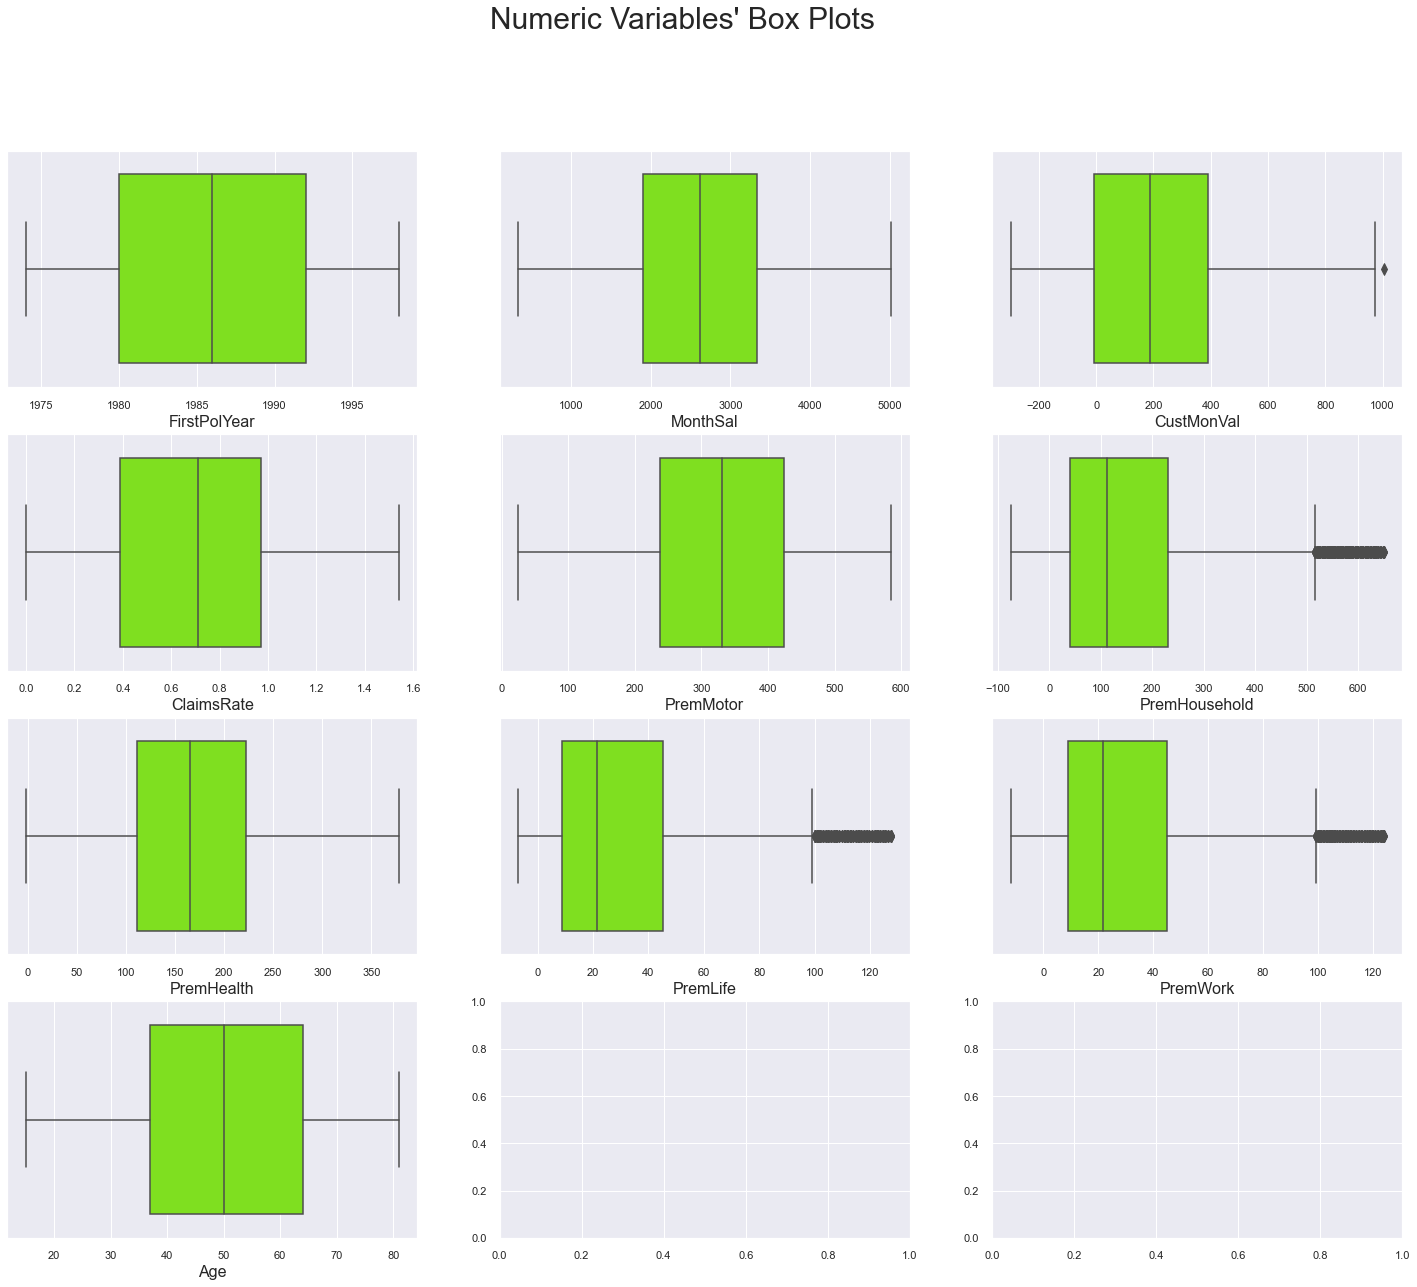

In [1223]:
box_plot_all_vars(df)

In [1224]:
df['FirstPolYear'].unique()

array([1985, 1991, 1990, 1986, 1979, 1988, 1981, 1976, 1983, 1977, 1998,
       1974, 1978, 1995, 1980, 1984, 1989, 1987, 1982, 1994, 1993, 1992,
       1997, 1996, 1975])

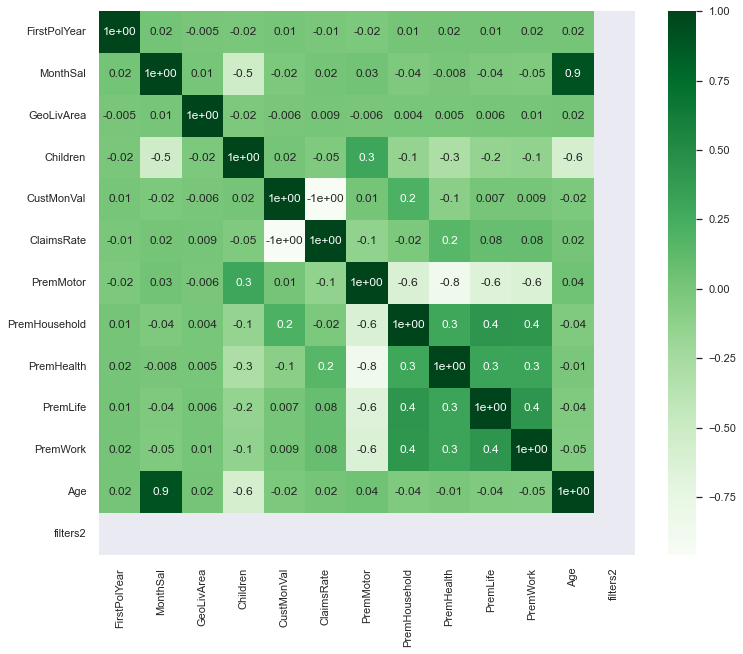

In [1225]:
def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Greens, fmt='.1')
    plt.show()
cor_pearson = df.corr()
cor_heatmap(cor_pearson)

#droppar monthsal?

In [1226]:
##Drop columns with very high correlations
df.drop(columns=['MonthSal','CustMonVal'], inplace=True)
metric_features.remove('MonthSal')
metric_features.remove('CustMonVal')

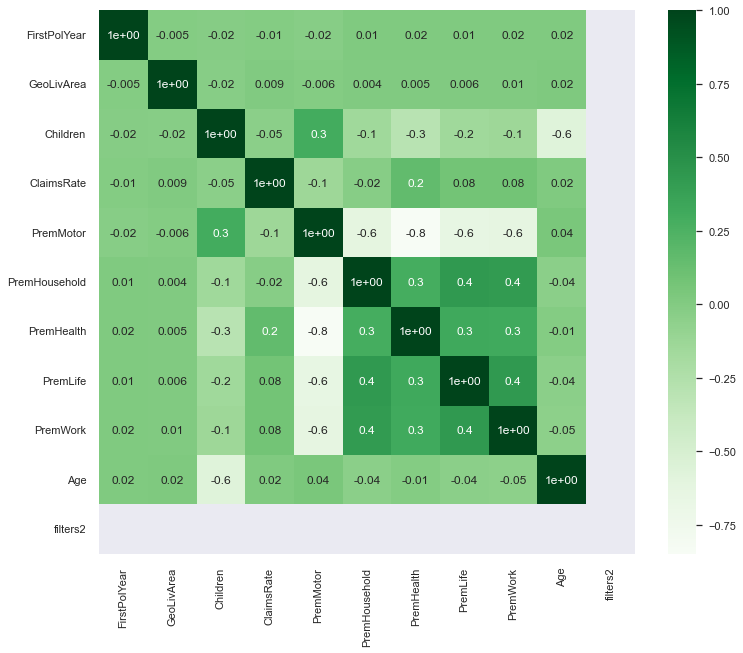

In [1227]:
cor_pearson = df.corr()
cor_heatmap(cor_pearson)

<AxesSubplot:xlabel='PremLife', ylabel='PremMotor'>

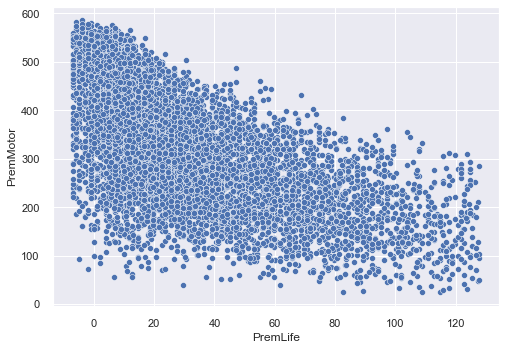

In [1228]:
sns.scatterplot(x='PremLife', y='PremMotor', data=df)

In [1229]:
df[metric_features].sample(5)

FirstPolYear  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
CustID                                                                   
850             1984        0.00     342.73          98.35      131.58   
3818            1992        0.79     354.29         158.35      190.59   
2518            1991        1.00     457.53          24.45      114.80   
6752            1976        0.90     189.59         270.60      263.94   
6031            1992        0.71     243.27         314.50      190.48   

        PremLife  PremWork  Age  
CustID                           
850        74.68     29.34   57  
3818       -1.00     35.45   58  
2518        8.89      6.78   48  
6752        3.89     75.46   60  
6031       77.57      8.67   63

### MinMaxScaler

In [1230]:
df_minmax=df.copy()
#normalize with minmaxscaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df_minmax[metric_features])
df_minmax[metric_features] = scaled_features

df_minmax.describe().T

count      mean       std  min       25%       50%       75%  \
FirstPolYear   8791.0  0.500308  0.274665  0.0  0.250000  0.500000  0.750000   
GeoLivArea     8791.0  2.710613  1.264542  1.0  1.000000  3.000000  4.000000   
Children       8791.0  0.716415  0.450764  0.0  0.000000  1.000000  1.000000   
ClaimsRate     8791.0  0.438961  0.204484  0.0  0.253247  0.461039  0.629870   
PremMotor      8791.0  0.543506  0.213610  0.0  0.381372  0.546285  0.712393   
PremHousehold  8791.0  0.312901  0.209308  0.0  0.158840  0.258633  0.421340   
PremHealth     8791.0  0.450363  0.198090  0.0  0.297570  0.439055  0.591351   
PremLife       8791.0  0.276508  0.214803  0.0  0.117158  0.212042  0.386963   
PremWork       8791.0  0.308062  0.211526  0.0  0.153705  0.248547  0.419469   
Age            8791.0  0.533500  0.240748  0.0  0.333333  0.530303  0.742424   

               max  
FirstPolYear   1.0  
GeoLivArea     4.0  
Children       1.0  
ClaimsRate     1.0  
PremMotor      1.0  
PremHousehold  1.0  
PremHealth     1.0  
PremLife       1.0  
PremWork       1.0  
Age            1.0

### StandartScaler

In [1231]:
df_st_scaler=df.copy()
#normalize with standart scaler
from sklearn.preprocessing import StandardScaler
standart_scaler = StandardScaler()
standart_scaler_features = standart_scaler.fit_transform(df_st_scaler[metric_features])
df_st_scaler[metric_features] = standart_scaler_features

df_st_scaler.describe().T

count          mean       std       min       25%       50%  \
FirstPolYear   8791.0 -1.185146e-14  1.000057 -1.821624 -0.911373 -0.001122   
GeoLivArea     8791.0  2.710613e+00  1.264542  1.000000  1.000000  3.000000   
Children       8791.0  7.164145e-01  0.450764  0.000000  0.000000  1.000000   
ClaimsRate     8791.0 -1.925431e-16  1.000057 -2.146803 -0.908264  0.107974   
PremMotor      8791.0  4.863461e-16  1.000057 -2.544528 -0.759063  0.013008   
PremHousehold  8791.0  4.146761e-17  1.000057 -1.495015 -0.736091 -0.259289   
PremHealth     8791.0  5.259257e-16  1.000057 -2.273656 -0.771378 -0.057088   
PremLife       8791.0  1.389200e-19  1.000057 -1.287340 -0.741888 -0.300134   
PremWork       8791.0 -2.681155e-17  1.000057 -1.456464 -0.729775 -0.281377   
Age            8791.0 -1.317593e-16  1.000057 -2.216134 -0.831483 -0.013281   

                    75%       max  
FirstPolYear   0.909129  1.819380  
GeoLivArea     4.000000  4.000000  
Children       1.000000  1.000000  
ClaimsRate     0.933667  2.743840  
PremMotor      0.790674  2.137163  
PremHousehold  0.518114  3.282908  
PremHealth     0.711779  2.774839  
PremLife       0.514242  3.368360  
PremWork       0.526712  3.271365  
Age            0.867860  1.937817

### Robust Scaler

In [1232]:
df_robust_scaler=df.copy()
#normalize with robust scaler
from sklearn.preprocessing import RobustScaler
robust_scaler = RobustScaler()
robust_scaler_features = robust_scaler.fit_transform(df_robust_scaler[metric_features])
df_robust_scaler[metric_features] = robust_scaler_features

df_robust_scaler.describe().T

count      mean       std       min       25%  50%       75%  \
FirstPolYear   8791.0  0.000616  0.549330 -1.000000 -0.500000  0.0  0.500000   
GeoLivArea     8791.0  2.710613  1.264542  1.000000  1.000000  3.0  4.000000   
Children       8791.0  0.716415  0.450764  0.000000  0.000000  1.0  1.000000   
ClaimsRate     8791.0 -0.058620  0.542939 -1.224138 -0.551724  0.0  0.448276   
PremMotor      8791.0 -0.008394  0.645308 -1.650304 -0.498195  0.0  0.501805   
PremHousehold  8791.0  0.206735  0.797363 -0.985267 -0.380163  0.0  0.619837   
PremHealth     8791.0  0.038491  0.674276 -1.494494 -0.481601  0.0  0.518399   
PremLife       8791.0  0.238935  0.796141 -0.785911 -0.351679  0.0  0.648321   
PremWork       8791.0  0.223940  0.795915 -0.935216 -0.356866  0.0  0.643134   
Age            8791.0  0.007815  0.588496 -1.296296 -0.481481  0.0  0.518519   

                    max  
FirstPolYear   1.000000  
GeoLivArea     4.000000  
Children       1.000000  
ClaimsRate     1.431034  
PremMotor      1.370656  
PremHousehold  2.824257  
PremHealth     1.909392  
PremLife       2.920473  
PremWork       2.827519  
Age            1.148148

In [1233]:
## Choosing standart scaler df
# df=df_st_scaler.copy()
df=df_minmax.copy()

In [1234]:
df[non_metric_features]

EducDeg  Children  GeoLivArea
CustID                                          
1       b'2 - High School'         1           1
3             b'1 - Basic'         0           3
4           b'3 - BSc/MSc'         1           4
5           b'3 - BSc/MSc'         1           4
6       b'2 - High School'         1           4
...                    ...       ...         ...
10290   b'2 - High School'         0           4
10292           b'4 - PhD'         0           2
10294       b'3 - BSc/MSc'         1           1
10295         b'1 - Basic'         1           2
10296           b'4 - PhD'         1           1

[8791 rows x 3 columns]

### One Hot Encoder
#### Using standart scaled DF

In [1235]:
##ONE HOT ENCODING
df_ohc = df[non_metric_features].copy()

ohc = OneHotEncoder(sparse=False)
ohc_feat = ohc.fit_transform(df_ohc)
ohc_feat_names = ohc.get_feature_names_out()
ohc_df = pd.DataFrame(ohc_feat, index=df_ohc.index, columns=ohc_feat_names)
ohc_df.drop(['Children_0'],axis=1, inplace=True)
ohc_df

EducDeg_b'1 - Basic'  EducDeg_b'2 - High School'  \
CustID                                                     
1                        0.0                         1.0   
3                        1.0                         0.0   
4                        0.0                         0.0   
5                        0.0                         0.0   
6                        0.0                         1.0   
...                      ...                         ...   
10290                    0.0                         1.0   
10292                    0.0                         0.0   
10294                    0.0                         0.0   
10295                    1.0                         0.0   
10296                    0.0                         0.0   

        EducDeg_b'3 - BSc/MSc'  EducDeg_b'4 - PhD'  Children_1  GeoLivArea_1  \
CustID                                                                         
1                          0.0                 0.0         1.0           1.0   
3                          0.0                 0.0         0.0           0.0   
4                          1.0                 0.0         1.0           0.0   
5                          1.0                 0.0         1.0           0.0   
6                          0.0                 0.0         1.0           0.0   
...                        ...                 ...         ...           ...   
10290                      0.0                 0.0         0.0           0.0   
10292                      0.0                 1.0         0.0           0.0   
10294                      1.0                 0.0         1.0           1.0   
10295                      0.0                 0.0         1.0           0.0   
10296                      0.0                 1.0         1.0           1.0   

        GeoLivArea_2  GeoLivArea_3  GeoLivArea_4  
CustID                                            
1                0.0           0.0           0.0  
3                0.0           1.0           0.0  
4                0.0           0.0           1.0  
5                0.0           0.0           1.0  
6                0.0           0.0           1.0  
...              ...           ...           ...  
10290            0.0           0.0           1.0  
10292            1.0           0.0           0.0  
10294            0.0           0.0           0.0  
10295            1.0           0.0           0.0  
10296            0.0           0.0           0.0  

[8791 rows x 9 columns]

In [1236]:
df_scaled=df.merge(ohc_df, on = 'CustID')
df_scaled.drop(['Children', 'EducDeg', 'GeoLivArea'],axis=1, inplace=True)
df_scaled

FirstPolYear  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
CustID                                                                   
1           0.458333    0.253247   0.626565       0.213329    0.390526   
3           0.708333    0.181818   0.323886       0.413674    0.333237   
4           0.666667    0.642857   0.281668       0.163467    0.824031   
5           0.500000    0.584416   0.560161       0.169613    0.485823   
6           0.500000    0.649351   0.742322       0.129696    0.307512   
...              ...         ...        ...            ...         ...   
10290       0.500000    0.435065   0.362537       0.477348    0.428823   
10292       0.416667    0.623377   0.658474       0.171892    0.462728   
10294       0.833333    0.136364   0.676114       0.287017    0.379715   
10295       0.291667    0.422078   0.292566       0.395235    0.527329   
10296       0.666667    0.175325   0.694753       0.234047    0.377085   

        PremLife  PremWork       Age  filters2  EducDeg_b'1 - Basic'  \
CustID                                                                 
1       0.400995  0.212567  0.287879      True                   0.0   
3       0.693073  0.816864  0.469697      True                   1.0   
4       0.314351  0.296814  0.303030      True                   0.0   
5       0.191402  0.393275  0.424242      True                   0.0   
6       0.103942  0.144728  0.681818      True                   0.0   
...          ...       ...       ...       ...                   ...   
10290   0.795382  0.602605  0.878788      True                   0.0   
10292   0.124582  0.197042  0.787879      True                   0.0   
10294   0.146039  0.124273  0.378788      True                   0.0   
10295   0.526394  0.919064  0.363636      True                   1.0   
10296   0.103126  0.183136  0.303030      True                   0.0   

        EducDeg_b'2 - High School'  EducDeg_b'3 - BSc/MSc'  \
CustID                                                       
1                              1.0                     0.0   
3                              0.0                     0.0   
4                              0.0                     1.0   
5                              0.0                     1.0   
6                              1.0                     0.0   
...                            ...                     ...   
10290                          1.0                     0.0   
10292                          0.0                     0.0   
10294                          0.0                     1.0   
10295                          0.0                     0.0   
10296                          0.0                     0.0   

        EducDeg_b'4 - PhD'  Children_1  GeoLivArea_1  GeoLivArea_2  \
CustID                                                               
1                      0.0         1.0           1.0           0.0   
3                      0.0         0.0           0.0           0.0   
4                      0.0         1.0           0.0           0.0   
5                      0.0         1.0           0.0           0.0   
6                      0.0         1.0           0.0           0.0   
...                    ...         ...           ...           ...   
10290                  0.0         0.0           0.0           0.0   
10292                  1.0         0.0           0.0           1.0   
10294                  0.0         1.0           1.0           0.0   
10295                  0.0         1.0           0.0           1.0   
10296                  1.0         1.0           1.0           0.0   

        GeoLivArea_3  GeoLivArea_4  
CustID                              
1                0.0           0.0  
3                1.0           0.0  
4                0.0           1.0  
5                0.0           1.0  
6                0.0           1.0  
...              ...           ...  
10290            0.0           1.0  
10292            0.0           0.0  
10294            0.0

#### Using MinMaxScaler

In [1237]:
##ONE HOT ENCODING
df_ohc = df_minmax[non_metric_features].copy()

ohc = OneHotEncoder(sparse=False)
ohc_feat = ohc.fit_transform(df_ohc)
ohc_feat_names = ohc.get_feature_names_out()
ohc_df = pd.DataFrame(ohc_feat, index=df_ohc.index, columns=ohc_feat_names)
ohc_df.drop(['Children_0'],axis=1, inplace=True)
ohc_df

EducDeg_b'1 - Basic'  EducDeg_b'2 - High School'  \
CustID                                                     
1                        0.0                         1.0   
3                        1.0                         0.0   
4                        0.0                         0.0   
5                        0.0                         0.0   
6                        0.0                         1.0   
...                      ...                         ...   
10290                    0.0                         1.0   
10292                    0.0                         0.0   
10294                    0.0                         0.0   
10295                    1.0                         0.0   
10296                    0.0                         0.0   

        EducDeg_b'3 - BSc/MSc'  EducDeg_b'4 - PhD'  Children_1  GeoLivArea_1  \
CustID                                                                         
1                          0.0                 0.0         1.0           1.0   
3                          0.0                 0.0         0.0           0.0   
4                          1.0                 0.0         1.0           0.0   
5                          1.0                 0.0         1.0           0.0   
6                          0.0                 0.0         1.0           0.0   
...                        ...                 ...         ...           ...   
10290                      0.0                 0.0         0.0           0.0   
10292                      0.0                 1.0         0.0           0.0   
10294                      1.0                 0.0         1.0           1.0   
10295                      0.0                 0.0         1.0           0.0   
10296                      0.0                 1.0         1.0           1.0   

        GeoLivArea_2  GeoLivArea_3  GeoLivArea_4  
CustID                                            
1                0.0           0.0           0.0  
3                0.0           1.0           0.0  
4                0.0           0.0           1.0  
5                0.0           0.0           1.0  
6                0.0           0.0           1.0  
...              ...           ...           ...  
10290            0.0           0.0           1.0  
10292            1.0           0.0           0.0  
10294            0.0           0.0           0.0  
10295            1.0           0.0           0.0  
10296            0.0           0.0           0.0  

[8791 rows x 9 columns]

In [1238]:
df_minmax=df_minmax.merge(ohc_df, on = 'CustID')
df_minmax.drop(['Children', 'EducDeg', 'GeoLivArea'],axis=1, inplace=True)
df_minmax

FirstPolYear  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
CustID                                                                   
1           0.458333    0.253247   0.626565       0.213329    0.390526   
3           0.708333    0.181818   0.323886       0.413674    0.333237   
4           0.666667    0.642857   0.281668       0.163467    0.824031   
5           0.500000    0.584416   0.560161       0.169613    0.485823   
6           0.500000    0.649351   0.742322       0.129696    0.307512   
...              ...         ...        ...            ...         ...   
10290       0.500000    0.435065   0.362537       0.477348    0.428823   
10292       0.416667    0.623377   0.658474       0.171892    0.462728   
10294       0.833333    0.136364   0.676114       0.287017    0.379715   
10295       0.291667    0.422078   0.292566       0.395235    0.527329   
10296       0.666667    0.175325   0.694753       0.234047    0.377085   

        PremLife  PremWork       Age  filters2  EducDeg_b'1 - Basic'  \
CustID                                                                 
1       0.400995  0.212567  0.287879      True                   0.0   
3       0.693073  0.816864  0.469697      True                   1.0   
4       0.314351  0.296814  0.303030      True                   0.0   
5       0.191402  0.393275  0.424242      True                   0.0   
6       0.103942  0.144728  0.681818      True                   0.0   
...          ...       ...       ...       ...                   ...   
10290   0.795382  0.602605  0.878788      True                   0.0   
10292   0.124582  0.197042  0.787879      True                   0.0   
10294   0.146039  0.124273  0.378788      True                   0.0   
10295   0.526394  0.919064  0.363636      True                   1.0   
10296   0.103126  0.183136  0.303030      True                   0.0   

        EducDeg_b'2 - High School'  EducDeg_b'3 - BSc/MSc'  \
CustID                                                       
1                              1.0                     0.0   
3                              0.0                     0.0   
4                              0.0                     1.0   
5                              0.0                     1.0   
6                              1.0                     0.0   
...                            ...                     ...   
10290                          1.0                     0.0   
10292                          0.0                     0.0   
10294                          0.0                     1.0   
10295                          0.0                     0.0   
10296                          0.0                     0.0   

        EducDeg_b'4 - PhD'  Children_1  GeoLivArea_1  GeoLivArea_2  \
CustID                                                               
1                      0.0         1.0           1.0           0.0   
3                      0.0         0.0           0.0           0.0   
4                      0.0         1.0           0.0           0.0   
5                      0.0         1.0           0.0           0.0   
6                      0.0         1.0           0.0           0.0   
...                    ...         ...           ...           ...   
10290                  0.0         0.0           0.0           0.0   
10292                  1.0         0.0           0.0           1.0   
10294                  0.0         1.0           1.0           0.0   
10295                  0.0         1.0           0.0           1.0   
10296                  1.0         1.0           1.0           0.0   

        GeoLivArea_3  GeoLivArea_4  
CustID                              
1                0.0           0.0  
3                1.0           0.0  
4                0.0           1.0  
5                0.0           1.0  
6                0.0           1.0  
...              ...           ...  
10290            0.0           1.0  
10292            0.0           0.0  
10294            0.0

In [1239]:
ProfileReport(
    df_scaled,
    title='Data Preprocessed Analysis',
    correlations={
        "pearson": {"calculate": True},
        "spearman": {"calculate": False},
        "kendall": {"calculate": False},
        "phi_k": {"calculate": False},
        "cramers": {"calculate": False},
    },
)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## PCA
#### Using standart scaler df

In [1240]:
##PCA
df_pca = df_scaled.copy()


pca = PCA()
pca_feat = pca.fit_transform(df_pca[metric_features])

In [1241]:
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
)

Eigenvalue  Difference  Proportion  Cumulative
1    0.134739    0.000000    0.341305    0.341305
2    0.075473   -0.059266    0.191180    0.532485
3    0.057891   -0.017582    0.146643    0.679128
4    0.043376   -0.014515    0.109876    0.789004
5    0.032169   -0.011207    0.081487    0.870490
6    0.025916   -0.006253    0.065647    0.936137
7    0.024757   -0.001159    0.062712    0.998849
8    0.000454   -0.024303    0.001151    1.000000

##### We can notice that only a reduction to 5 components (~82%) would be representative of the data set. Since originally, we had 13 features, it doesn't make sense to keep 5 components.
#### Let's try with the df from min max scaler...


In [1242]:
##PCA
df_pca_min_max = df_minmax.copy()


pca_min_max = PCA()
pca_feat_min_max = pca_min_max.fit_transform(df_pca_min_max[metric_features])

In [1243]:
pd.DataFrame(
    {"Eigenvalue": pca_min_max.explained_variance_,
     "Difference": np.insert(np.diff(pca_min_max.explained_variance_), 0, 0),
     "Proportion": pca_min_max.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca_min_max.explained_variance_ratio_)},
    index=range(1, pca_min_max.n_components_ + 1)
)

Eigenvalue  Difference  Proportion  Cumulative
1    0.134739    0.000000    0.341305    0.341305
2    0.075473   -0.059266    0.191180    0.532485
3    0.057891   -0.017582    0.146643    0.679128
4    0.043376   -0.014515    0.109876    0.789004
5    0.032169   -0.011207    0.081487    0.870490
6    0.025916   -0.006253    0.065647    0.936137
7    0.024757   -0.001159    0.062712    0.998849
8    0.000454   -0.024303    0.001151    1.000000

##### Now it's clear that with only 3 components, we have 90% of explained variance
##### Let's keep this DF to visualize PCA

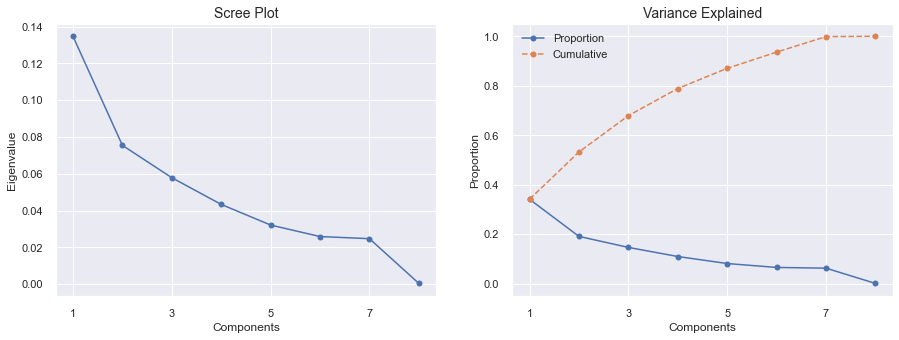

In [1244]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


ax1.plot(pca_min_max.explained_variance_, marker=".", markersize=12)
ax2.plot(pca_min_max.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca_min_max.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")


ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca_min_max.n_components_, 2))
ax1.set_xticklabels(range(1, pca_min_max.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca_min_max.n_components_, 2))
ax2.set_xticklabels(range(1, pca_min_max.n_components_ + 1, 2))

plt.show()

In [1245]:
pca_min_max = PCA(n_components=3)
pca_feat_min_max = pca_min_max.fit_transform(df_pca_min_max[metric_features])
pca_feat_names = [f"PC{i}" for i in range(pca_min_max.n_components_)]
pca_df = pd.DataFrame(pca_feat_min_max, index=df_pca_min_max.index, columns=pca_feat_names) 
pca_df

PC0       PC1       PC2
CustID                              
1      -0.100062  0.052266 -0.264202
3       0.498324 -0.193903 -0.109105
4       0.280319 -0.138911 -0.173265
5      -0.035509  0.009575 -0.091183
6      -0.372881 -0.015710  0.151013
...          ...       ...       ...
10290   0.486942 -0.008595  0.342853
10292  -0.228926  0.063605  0.273775
10294  -0.252478 -0.335237 -0.214025
10295   0.567407  0.235374 -0.147814
10296  -0.277196 -0.163730 -0.275742

[8791 rows x 3 columns]

In [1246]:
df_pca_min_max = pd.concat([df_pca_min_max, pca_df], axis=1)
df_pca_min_max.head()

FirstPolYear  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
CustID                                                                   
1           0.458333    0.253247   0.626565       0.213329    0.390526   
3           0.708333    0.181818   0.323886       0.413674    0.333237   
4           0.666667    0.642857   0.281668       0.163467    0.824031   
5           0.500000    0.584416   0.560161       0.169613    0.485823   
6           0.500000    0.649351   0.742322       0.129696    0.307512   

        PremLife  PremWork       Age  filters2  EducDeg_b'1 - Basic'  ...  \
CustID                                                                ...   
1       0.400995  0.212567  0.287879      True                   0.0  ...   
3       0.693073  0.816864  0.469697      True                   1.0  ...   
4       0.314351  0.296814  0.303030      True                   0.0  ...   
5       0.191402  0.393275  0.424242      True                   0.0  ...   
6       0.103942  0.144728  0.681818      True                   0.0  ...   

        EducDeg_b'3 - BSc/MSc'  EducDeg_b'4 - PhD'  Children_1  GeoLivArea_1  \
CustID                                                                         
1                          0.0                 0.0         1.0           1.0   
3                          0.0                 0.0         0.0           0.0   
4                          1.0                 0.0         1.0           0.0   
5                          1.0                 0.0         1.0           0.0   
6                          0.0                 0.0         1.0           0.0   

        GeoLivArea_2  GeoLivArea_3  GeoLivArea_4       PC0       PC1       PC2  
CustID                                                                          
1                0.0           0.0           0.0 -0.100062  0.052266 -0.264202  
3                0.0           1.0           0.0  0.498324 -0.193903 -0.109105  
4                0.0           0.0           1.0  0.280319 -0.138911 -0.173265  
5                0.0           0.0           1.0 -0.035509  0.009575 -0.091183  
6                0.0           0.0           1.0 -0.372881 -0.015710  0.151013  

[5 rows x 21 columns]

In [1247]:
def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: red'
    elif val > 0.45:
        color = 'background-color: green'
    else:
        color = ''
    return color
    


# Interpreting each Principal Component
loadings = df_pca_min_max[metric_features + pca_feat_names].corr().loc[metric_features, pca_feat_names]
loadings.style.applymap(_color_red_or_green)

In [1248]:
df_pca_min_max['HighScore'] = df_pca_min_max[['PC0', 'PC1', 'PC2']].idxmax(axis=1)
df_pca_min_max

FirstPolYear  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
CustID                                                                   
1           0.458333    0.253247   0.626565       0.213329    0.390526   
3           0.708333    0.181818   0.323886       0.413674    0.333237   
4           0.666667    0.642857   0.281668       0.163467    0.824031   
5           0.500000    0.584416   0.560161       0.169613    0.485823   
6           0.500000    0.649351   0.742322       0.129696    0.307512   
...              ...         ...        ...            ...         ...   
10290       0.500000    0.435065   0.362537       0.477348    0.428823   
10292       0.416667    0.623377   0.658474       0.171892    0.462728   
10294       0.833333    0.136364   0.676114       0.287017    0.379715   
10295       0.291667    0.422078   0.292566       0.395235    0.527329   
10296       0.666667    0.175325   0.694753       0.234047    0.377085   

        PremLife  PremWork       Age  filters2  EducDeg_b'1 - Basic'  ...  \
CustID                                                                ...   
1       0.400995  0.212567  0.287879      True                   0.0  ...   
3       0.693073  0.816864  0.469697      True                   1.0  ...   
4       0.314351  0.296814  0.303030      True                   0.0  ...   
5       0.191402  0.393275  0.424242      True                   0.0  ...   
6       0.103942  0.144728  0.681818      True                   0.0  ...   
...          ...       ...       ...       ...                   ...  ...   
10290   0.795382  0.602605  0.878788      True                   0.0  ...   
10292   0.124582  0.197042  0.787879      True                   0.0  ...   
10294   0.146039  0.124273  0.378788      True                   0.0  ...   
10295   0.526394  0.919064  0.363636      True                   1.0  ...   
10296   0.103126  0.183136  0.303030      True                   0.0  ...   

        EducDeg_b'4 - PhD'  Children_1  GeoLivArea_1  GeoLivArea_2  \
CustID                                                               
1                      0.0         1.0           1.0           0.0   
3                      0.0         0.0           0.0           0.0   
4                      0.0         1.0           0.0           0.0   
5                      0.0         1.0           0.0           0.0   
6                      0.0         1.0           0.0           0.0   
...                    ...         ...           ...           ...   
10290                  0.0         0.0           0.0           0.0   
10292                  1.0         0.0           0.0           1.0   
10294                  0.0         1.0           1.0           0.0   
10295                  0.0         1.0           0.0           1.0   
10296                  1.0         1.0           1.0           0.0   

        GeoLivArea_3  GeoLivArea_4       PC0       PC1       PC2  HighScore  
CustID                                                                       
1                0.0           0.0 -0.100062  0.052266 -0.264202        PC1  
3                1.0           0.0  0.498324 -0.193903 -0.109105        PC0  
4                0.0           1.0  0.280319 -0.138911 -0.173265        PC0  
5                0.0           1.0 -0.035509  0.009575 -0.091183        PC1  
6                0.0           1.0 -0.372881 -0.015710  0.151013        PC2  
...              ...           ...       ...       ...       ...        ...  
10290            0.0           1.0  0.486942 -0.008595  0.342853        PC0  
10292            0.0           0.0 -0.228926  0.063605  0.273775        PC2  
10294            0.0           0.0 -0.252478 -0.335237 -0.214025        PC2  
10295            0.0           0.0  0.567407  0.235374 -0.147814        PC0  
10296            0.0           0.0 -0.277196 -0.163730 -0.275742        PC1  

[8791 rows x 22 columns]

### At this point, we have 2 different Dataframes. One from min max scaler with 3 Principal components. And another from standart scaler without PCA.
#### Let's see wich one performs best when doing clustering

In [1249]:
df_pca_min_max.head()

FirstPolYear  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
CustID                                                                   
1           0.458333    0.253247   0.626565       0.213329    0.390526   
3           0.708333    0.181818   0.323886       0.413674    0.333237   
4           0.666667    0.642857   0.281668       0.163467    0.824031   
5           0.500000    0.584416   0.560161       0.169613    0.485823   
6           0.500000    0.649351   0.742322       0.129696    0.307512   

        PremLife  PremWork       Age  filters2  EducDeg_b'1 - Basic'  ...  \
CustID                                                                ...   
1       0.400995  0.212567  0.287879      True                   0.0  ...   
3       0.693073  0.816864  0.469697      True                   1.0  ...   
4       0.314351  0.296814  0.303030      True                   0.0  ...   
5       0.191402  0.393275  0.424242      True                   0.0  ...   
6       0.103942  0.144728  0.681818      True                   0.0  ...   

        EducDeg_b'4 - PhD'  Children_1  GeoLivArea_1  GeoLivArea_2  \
CustID                                                               
1                      0.0         1.0           1.0           0.0   
3                      0.0         0.0           0.0           0.0   
4                      0.0         1.0           0.0           0.0   
5                      0.0         1.0           0.0           0.0   
6                      0.0         1.0           0.0           0.0   

        GeoLivArea_3  GeoLivArea_4       PC0       PC1       PC2  HighScore  
CustID                                                                       
1                0.0           0.0 -0.100062  0.052266 -0.264202        PC1  
3                1.0           0.0  0.498324 -0.193903 -0.109105        PC0  
4                0.0           1.0  0.280319 -0.138911 -0.173265        PC0  
5                0.0           1.0 -0.035509  0.009575 -0.091183        PC1  
6                0.0           1.0 -0.372881 -0.015710  0.151013        PC2  

[5 rows x 22 columns]

In [1250]:
df_st_scaler = df_pca.copy()
df_st_scaler.head()

FirstPolYear  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
CustID                                                                   
1           0.458333    0.253247   0.626565       0.213329    0.390526   
3           0.708333    0.181818   0.323886       0.413674    0.333237   
4           0.666667    0.642857   0.281668       0.163467    0.824031   
5           0.500000    0.584416   0.560161       0.169613    0.485823   
6           0.500000    0.649351   0.742322       0.129696    0.307512   

        PremLife  PremWork       Age  filters2  EducDeg_b'1 - Basic'  \
CustID                                                                 
1       0.400995  0.212567  0.287879      True                   0.0   
3       0.693073  0.816864  0.469697      True                   1.0   
4       0.314351  0.296814  0.303030      True                   0.0   
5       0.191402  0.393275  0.424242      True                   0.0   
6       0.103942  0.144728  0.681818      True                   0.0   

        EducDeg_b'2 - High School'  EducDeg_b'3 - BSc/MSc'  \
CustID                                                       
1                              1.0                     0.0   
3                              0.0                     0.0   
4                              0.0                     1.0   
5                              0.0                     1.0   
6                              1.0                     0.0   

        EducDeg_b'4 - PhD'  Children_1  GeoLivArea_1  GeoLivArea_2  \
CustID                                                               
1                      0.0         1.0           1.0           0.0   
3                      0.0         0.0           0.0           0.0   
4                      0.0         1.0           0.0           0.0   
5                      0.0         1.0           0.0           0.0   
6                      0.0         1.0           0.0           0.0   

        GeoLivArea_3  GeoLivArea_4  
CustID                              
1                0.0           0.0  
3                1.0           0.0  
4                0.0           1.0  
5                0.0           1.0  
6                0.0           1.0

## Hierarchical Clustering

In [1251]:
# Characterizing the clusters
df_concat = pd.concat((df, pd.Series(hc_labels, name='labels')), axis=1)
df_concat.groupby('labels').mean()

# Performing HC
hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=5)
hc_labels = hclust.fit_predict(df[metric_features])
hc_labels

# Computing SST
X = df[metric_features].values
sst = np.sum(np.square(X - X.mean(axis=0)), axis=0)

# Computing SSW
ssw_iter = []
for i in np.unique(hc_labels):
    X_k = X[hc_labels == i]
    ssw_iter.append(np.sum(np.square(X_k - X_k.mean(axis=0)), axis=0))
ssw = np.sum(ssw_iter, axis=0)

# Computing SSB
ssb_iter = []
for i in np.unique(hc_labels):
    X_k = X[hc_labels == i]
    ssb_iter.append(X_k.shape[0] * np.square(X_k.mean(axis=0) - X.mean(axis=0)))
ssb = np.sum(ssb_iter, axis=0)

# Verifying the formula
np.round(sst) == np.round((ssw + ssb))

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [1252]:
df_pca.columns

Index(['FirstPolYear', 'ClaimsRate', 'PremMotor', 'PremHousehold',
       'PremHealth', 'PremLife', 'PremWork', 'Age', 'filters2',
       'EducDeg_b'1 - Basic'', 'EducDeg_b'2 - High School'',
       'EducDeg_b'3 - BSc/MSc'', 'EducDeg_b'4 - PhD'', 'Children_1',
       'GeoLivArea_1', 'GeoLivArea_2', 'GeoLivArea_3', 'GeoLivArea_4'],
      dtype='object')

In [1253]:
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
    Parameters:
    df (DataFrame): Dataset to apply clustering
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods
    min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
    Returns:
    ndarray: R2 values for the range of cluster solutions
    """
    def get_ss(df):
        ss = np.sum(df.var() * (df.count() - 1))
        return ss  # return sum of sum of squares of each df variable
    
    sst = get_ss(df)  # get total sum of squares
    
    r2 = []  # where we will store the R2 metrics for each cluster solution
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        cluster = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link_method)
        
        
        hclabels = cluster.fit_predict(df) #get cluster labels
        
        
        df_concat = pd.concat((df, pd.Series(hclabels, name='labels')), axis=1)  # concat df with labels
        
        
        ssw_labels = df_concat.groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
        
        
        ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
        
        
        r2.append(ssb / sst)  # save the R2 of the given cluster solution
        
    return np.array(r2)

In [1254]:
df_aa=df_pca[metric_features]
df_aa

FirstPolYear  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
CustID                                                                   
1           0.458333    0.253247   0.626565       0.213329    0.390526   
3           0.708333    0.181818   0.323886       0.413674    0.333237   
4           0.666667    0.642857   0.281668       0.163467    0.824031   
5           0.500000    0.584416   0.560161       0.169613    0.485823   
6           0.500000    0.649351   0.742322       0.129696    0.307512   
...              ...         ...        ...            ...         ...   
10290       0.500000    0.435065   0.362537       0.477348    0.428823   
10292       0.416667    0.623377   0.658474       0.171892    0.462728   
10294       0.833333    0.136364   0.676114       0.287017    0.379715   
10295       0.291667    0.422078   0.292566       0.395235    0.527329   
10296       0.666667    0.175325   0.694753       0.234047    0.377085   

        PremLife  PremWork       Age  
CustID                                
1       0.400995  0.212567  0.287879  
3       0.693073  0.816864  0.469697  
4       0.314351  0.296814  0.303030  
5       0.191402  0.393275  0.424242  
6       0.103942  0.144728  0.681818  
...          ...       ...       ...  
10290   0.795382  0.602605  0.878788  
10292   0.124582  0.197042  0.787879  
10294   0.146039  0.124273  0.378788  
10295   0.526394  0.919064  0.363636  
10296   0.103126  0.183136  0.303030  

[8791 rows x 8 columns]

In [1255]:
# df_aa.describe().T

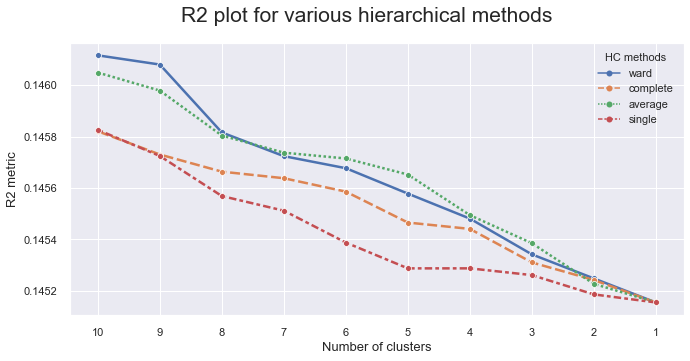

In [1256]:
# Prepare input
hc_methods = ["ward", "complete", "average", "single"]
# Call function defined above to obtain the R2 statistic for each hc_method
max_nclus = 10
r2_hc_methods = np.vstack(
    [
        get_r2_hc(df=df[metric_features], link_method=link, max_nclus=max_nclus) 
        for link in hc_methods
    ]
).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  # invert x axis
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show()

In [1257]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(df[metric_features])

array([5156, 4715, 7660, ...,    3,    1,    0], dtype=int64)

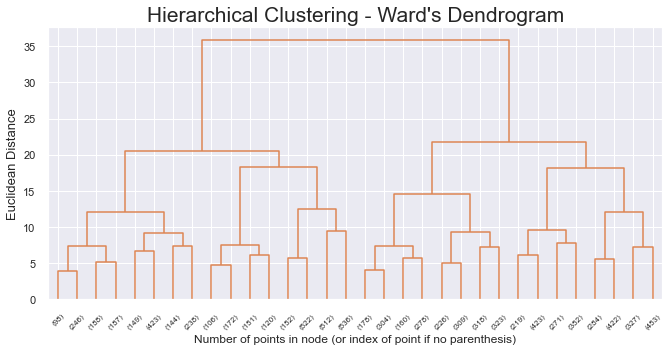

In [1258]:
# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))

# This threshold intercepts one of the dendrogram's largest lines
y_threshold = 150

dendrogram(linkage_matrix, truncate_mode='level', p=4, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

In [1272]:
# 3 cluster solution
linkage = 'ward'
distance = 'euclidean'
hc4lust = AgglomerativeClustering(linkage=linkage, affinity=distance, n_clusters=2)
hc4_labels = hc4lust.fit_predict(df[metric_features])

In [1273]:
# Characterizing the 3 clusters
df_concat = pd.concat((df_pca, pd.Series(hc4_labels, name='labels')), axis=1)
df_concat_mean=df_concat.groupby('labels').mean()
df_concat_mean

FirstPolYear  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
labels                                                                   
0.0         0.505137    0.440204   0.542986       0.315185    0.450750   
1.0         0.498004    0.437491   0.544273       0.306903    0.451131   

        PremLife  PremWork       Age  EducDeg_b'1 - Basic'  \
labels                                                       
0.0     0.275184  0.307932  0.536735              0.069347   
1.0     0.277193  0.307475  0.530330              0.077196   

        EducDeg_b'2 - High School'  EducDeg_b'3 - BSc/MSc'  \
labels                                                       
0.0                       0.325789                0.526848   
1.0                       0.324164                0.522331   

        EducDeg_b'4 - PhD'  Children_1  GeoLivArea_1  GeoLivArea_2  \
labels                                                               
0.0               0.078016    0.723092      0.293764      0.101854   
1.0               0.076309    0.710145      0.302277      0.098787   

        GeoLivArea_3  GeoLivArea_4  
labels                              
0.0         0.200578      0.403804  
1.0         0.201715      0.397220

In [1274]:
                                            #### IT IS VERY DIFFICULT TO INTERPRET CLUSTERS WITH SO MANY DATA POINTS USING SCATTER PLOTS
# sns.scatterplot(x="PremLife",
#                     y="Age",
#                     data=df_concat,
#                     hue='labels')

In [1275]:
#labels need to be present, so it can check wich cluster each row belongs
metric_features.append('labels')

df_concat_means = pd.concat([pd.DataFrame(df_concat[metric_features].mean().drop('labels'), columns=['mean']), 
                   df_concat[metric_features].groupby('labels').mean().T], axis=1)

df_concat_means.drop(columns=['mean'], inplace=True)
df_concat_means

0.0       1.0
FirstPolYear   0.505137  0.498004
ClaimsRate     0.440204  0.437491
PremMotor      0.542986  0.544273
PremHousehold  0.315185  0.306903
PremHealth     0.450750  0.451131
PremLife       0.275184  0.277193
PremWork       0.307932  0.307475
Age            0.536735  0.530330

In [1276]:
df_concat['labels'].value_counts()

0.0    4847
1.0    3944
Name: labels, dtype: int64

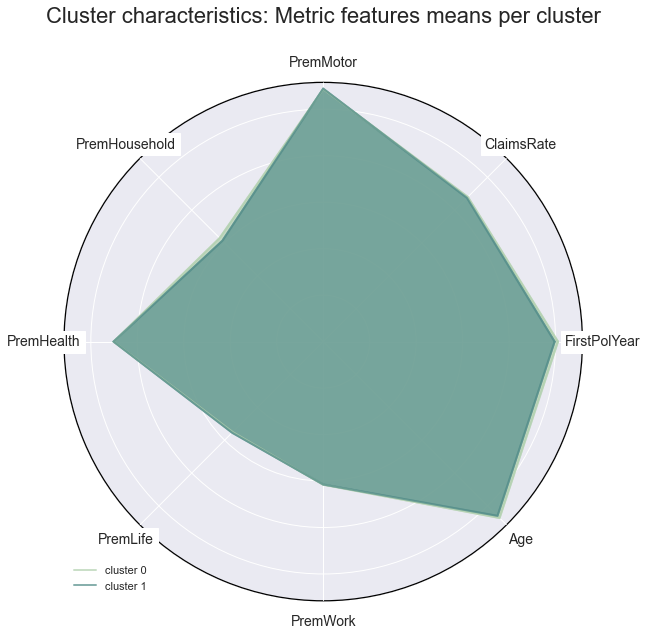

In [1277]:
cluster_colors = ['#b4d2b1', '#568f8b', '#1d4a60', '#8B8378', '#FFEFDB', '#0000FF', '#A52A2A']

class Radar(object):
    def __init__(self, figure, title, labels, rect=None):
        if rect is None:
            rect = [0.05, 0.05, 0.9, 0.9]

        self.n = len(title)
        self.angles = np.arange(0, 360, 360.0/self.n)
        
        self.axes = [figure.add_axes(rect, projection='polar', label='axes%d' % i) for i in range(self.n)]
        self.ax = self.axes[0]
        self.ax.set_thetagrids(self.angles, labels=title, fontsize=14, backgroundcolor="white",zorder=999) # Feature names
        self.ax.set_yticklabels([])
        
        for ax in self.axes[1:]:
            ax.xaxis.set_visible(False)
            ax.set_yticklabels([])
            ax.set_zorder(-99)

        for ax, angle, label in zip(self.axes, self.angles, labels):
            ax.spines['polar'].set_color('black')
            ax.spines['polar'].set_zorder(-99)
                     
    def plot(self, values, *args, **kw):
        angle = np.deg2rad(np.r_[self.angles, self.angles[0]])
        values = np.r_[values, values[0]]
        self.ax.plot(angle, values, *args, **kw)
        kw['label'] = '_noLabel'
        self.ax.fill(angle, values,*args,**kw)

fig = plt.figure(figsize=(8, 8))
no_features = len(hc4lust.feature_names_in_)
radar = Radar(fig, hc4lust.feature_names_in_, np.unique(hc4lust.labels_))

for k in range(0,hc4lust.n_clusters):
    cluster_data = df_concat_means[k].values.tolist()
    radar.plot(cluster_data,  '-', lw=2, color=cluster_colors[k], alpha=0.7, label='cluster {}'.format(k))

radar.ax.legend()
radar.ax.set_title("Cluster characteristics: Metric features means per cluster", size=22, pad=60)
plt.show()

## K-Means

In [1278]:
## df from standart scaler, without pca
df_std = df_pca.copy()
df_std

FirstPolYear  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
CustID                                                                   
1           0.458333    0.253247   0.626565       0.213329    0.390526   
3           0.708333    0.181818   0.323886       0.413674    0.333237   
4           0.666667    0.642857   0.281668       0.163467    0.824031   
5           0.500000    0.584416   0.560161       0.169613    0.485823   
6           0.500000    0.649351   0.742322       0.129696    0.307512   
...              ...         ...        ...            ...         ...   
10290       0.500000    0.435065   0.362537       0.477348    0.428823   
10292       0.416667    0.623377   0.658474       0.171892    0.462728   
10294       0.833333    0.136364   0.676114       0.287017    0.379715   
10295       0.291667    0.422078   0.292566       0.395235    0.527329   
10296       0.666667    0.175325   0.694753       0.234047    0.377085   

        PremLife  PremWork       Age  filters2  EducDeg_b'1 - Basic'  \
CustID                                                                 
1       0.400995  0.212567  0.287879      True                   0.0   
3       0.693073  0.816864  0.469697      True                   1.0   
4       0.314351  0.296814  0.303030      True                   0.0   
5       0.191402  0.393275  0.424242      True                   0.0   
6       0.103942  0.144728  0.681818      True                   0.0   
...          ...       ...       ...       ...                   ...   
10290   0.795382  0.602605  0.878788      True                   0.0   
10292   0.124582  0.197042  0.787879      True                   0.0   
10294   0.146039  0.124273  0.378788      True                   0.0   
10295   0.526394  0.919064  0.363636      True                   1.0   
10296   0.103126  0.183136  0.303030      True                   0.0   

        EducDeg_b'2 - High School'  EducDeg_b'3 - BSc/MSc'  \
CustID                                                       
1                              1.0                     0.0   
3                              0.0                     0.0   
4                              0.0                     1.0   
5                              0.0                     1.0   
6                              1.0                     0.0   
...                            ...                     ...   
10290                          1.0                     0.0   
10292                          0.0                     0.0   
10294                          0.0                     1.0   
10295                          0.0                     0.0   
10296                          0.0                     0.0   

        EducDeg_b'4 - PhD'  Children_1  GeoLivArea_1  GeoLivArea_2  \
CustID                                                               
1                      0.0         1.0           1.0           0.0   
3                      0.0         0.0           0.0           0.0   
4                      0.0         1.0           0.0           0.0   
5                      0.0         1.0           0.0           0.0   
6                      0.0         1.0           0.0           0.0   
...                    ...         ...           ...           ...   
10290                  0.0         0.0           0.0           0.0   
10292                  1.0         0.0           0.0           1.0   
10294                  0.0         1.0           1.0           0.0   
10295                  0.0         1.0           0.0           1.0   
10296                  1.0         1.0           1.0           0.0   

        GeoLivArea_3  GeoLivArea_4  
CustID                              
1                0.0           0.0  
3                1.0           0.0  
4                0.0           1.0  
5                0.0           1.0  
6                0.0           1.0  
...              ...           ...  
10290            0.0           1.0  
10292            0.0           0.0  
10294            0.0

In [1279]:
metric_features.remove('labels')

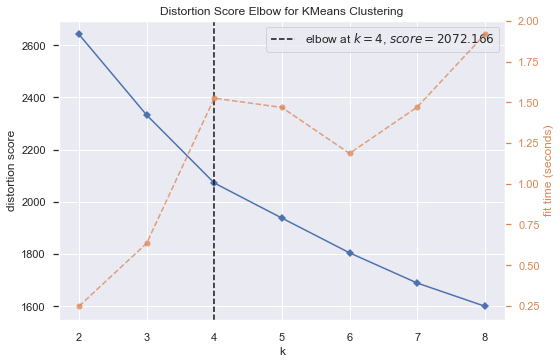

In [1280]:
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

visualizer = KElbowVisualizer(KMeans(init='k-means++', n_init=20), k=(2,9),ax=ax)
visualizer.fit(df_std[metric_features])

ax.set_xticks(range(2,9))
visualizer.show()
plt.show()

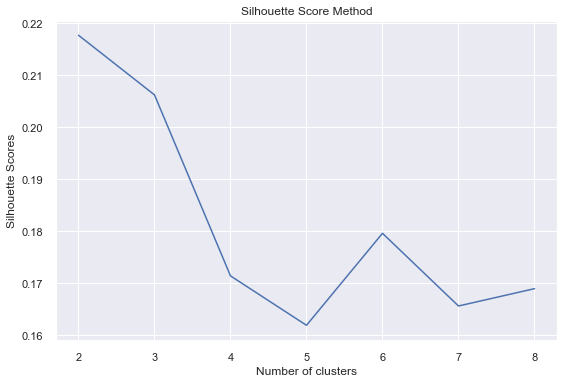

In [1268]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 9):
    km = KMeans(n_clusters=k, 
                init='k-means++', 
                n_init=20, 
                # random_state=42, 
                # algorithm='auto'
                )
    km.fit(df[metric_features])
    silhouette_scores.append(silhouette_score(df_std[metric_features], km.labels_))

fig, ax = plt.subplots()
ax.plot(range(2, 9), silhouette_scores, 'bx-')
ax.set_title('Silhouette Score Method')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette Scores')
plt.xticks(range(2, 9))
plt.tight_layout()
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.2177406989540564
For n_clusters = 3, the average silhouette_score is : 0.20617658758534319
For n_clusters = 4, the average silhouette_score is : 0.1714592205717668
For n_clusters = 5, the average silhouette_score is : 0.16190480488987627
For n_clusters = 6, the average silhouette_score is : 0.17984077484484368
For n_clusters = 7, the average silhouette_score is : 0.16492053378373975
For n_clusters = 8, the average silhouette_score is : 0.16898082269209702
For n_clusters = 9, the average silhouette_score is : 0.16858345019269227
For n_clusters = 10, the average silhouette_score is : 0.1699593066583786


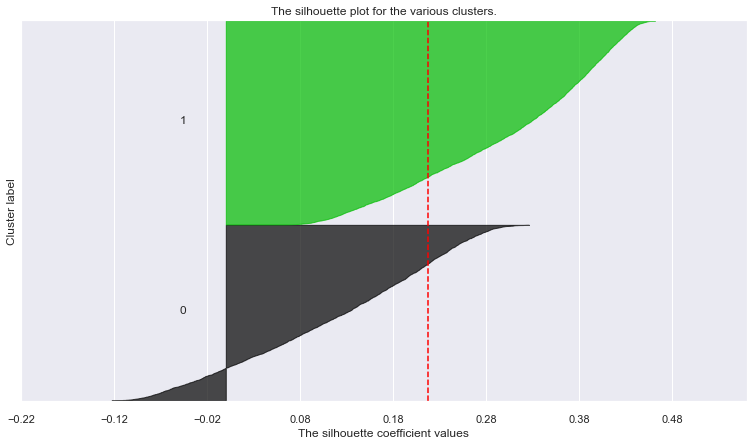

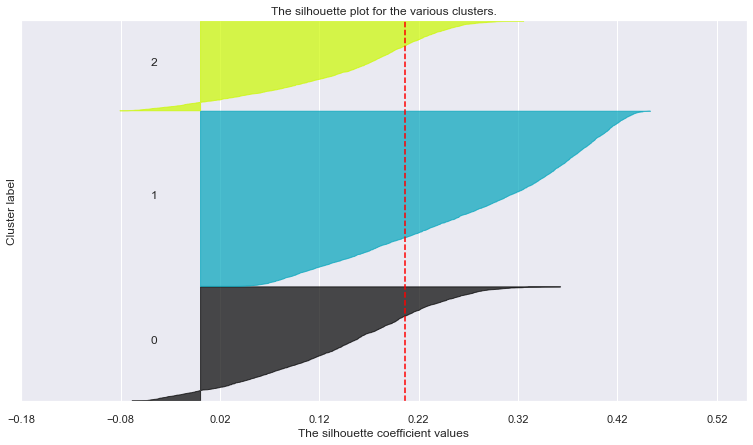

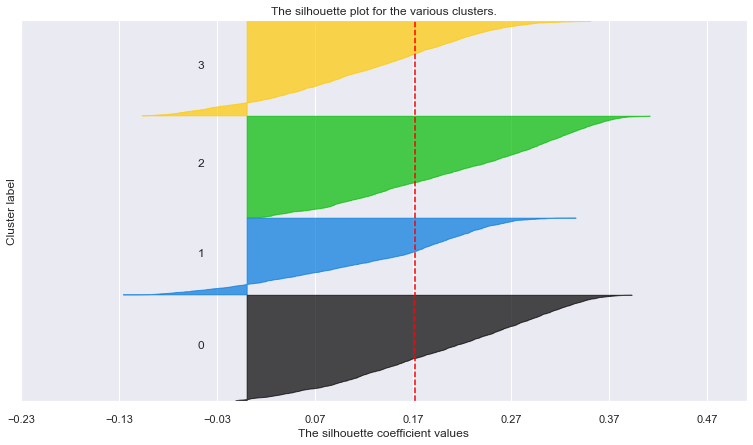

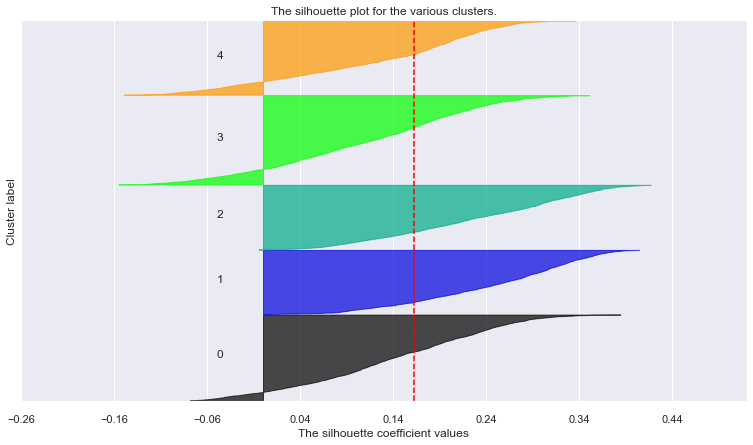

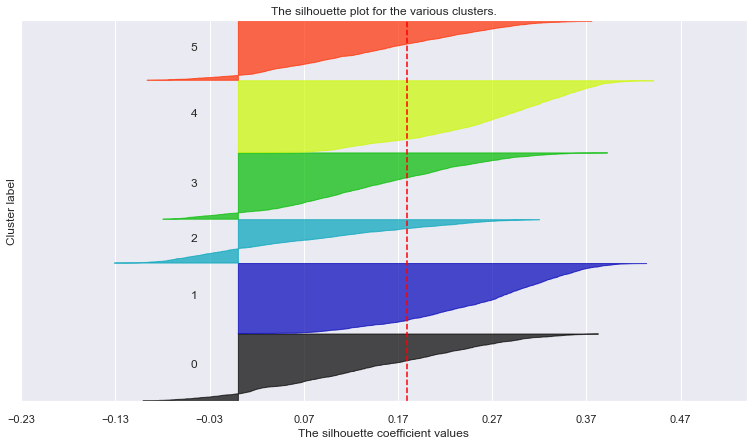

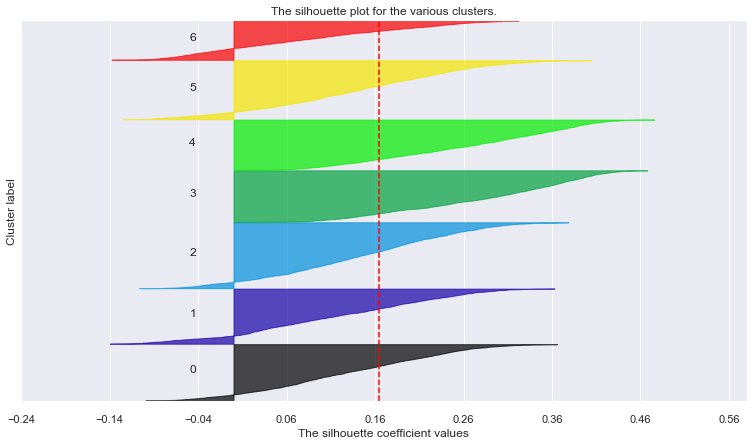

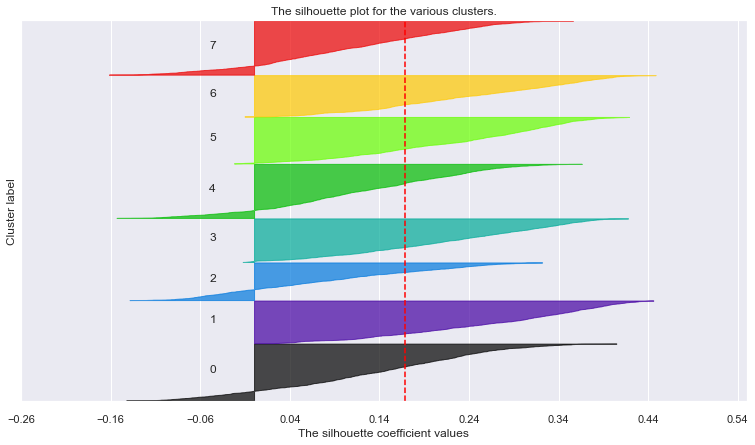

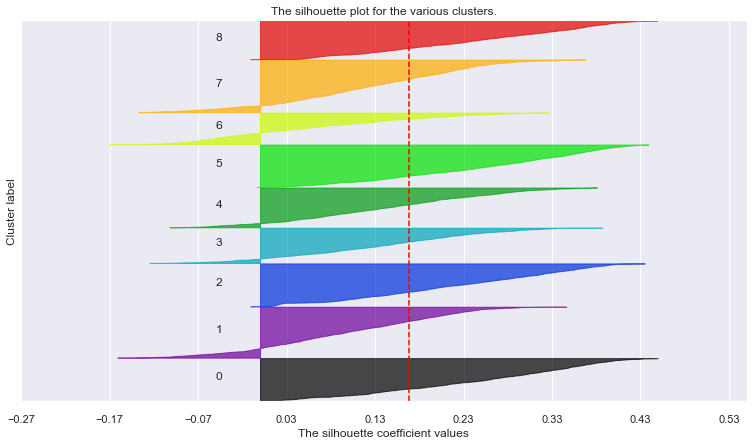

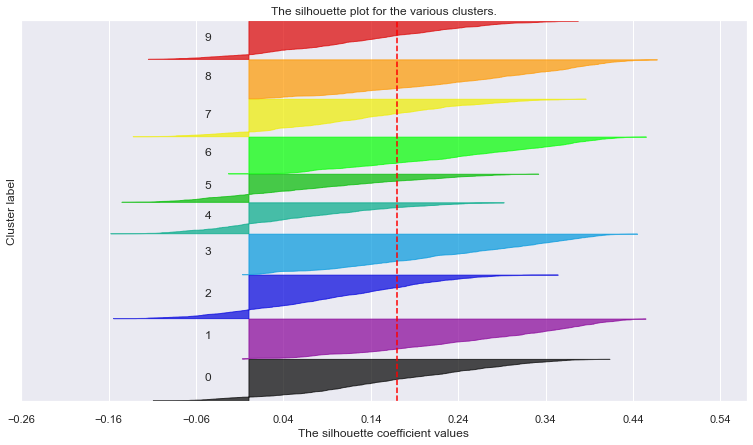

In [1269]:
range_clusters = range(1, 11)
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score, silhouette_samples

# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=20, random_state=1)
    cluster_labels = kmclust.fit_predict(df_std[metric_features])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df_std[metric_features], cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_std[metric_features], cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df_std[metric_features]) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

In [1270]:
# final cluster solution
number_clusters = 2
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=20, random_state=1)
km_labels = kmclust.fit_predict(df_std[metric_features])
km_labels

array([1, 0, 0, ..., 1, 0, 1])

In [1271]:
# Characterizing the final clusters
df_std = pd.concat((df_std, pd.Series(km_labels, name='labels')), axis=1)
df_std.groupby('labels').mean()

FirstPolYear  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
labels                                                                   
0.0         0.504646    0.436181   0.543217       0.308977    0.452060   
1.0         0.499609    0.441395   0.543861       0.313607    0.449943   

        PremLife  PremWork       Age  EducDeg_b'1 - Basic'  \
labels                                                       
0.0     0.277106  0.307742  0.529872              0.080460   
1.0     0.275210  0.307714  0.537285              0.066354   

        EducDeg_b'2 - High School'  EducDeg_b'3 - BSc/MSc'  \
labels                                                       
0.0                       0.324713                0.519828   
1.0                       0.325358                0.529107   

        EducDeg_b'4 - PhD'  Children_1  GeoLivArea_1  GeoLivArea_2  \
labels                                                               
0.0               0.075000    0.716667      0.302299      0.099713   
1.0               0.079181    0.717810      0.293537      0.101135   

        GeoLivArea_3  GeoLivArea_4  
labels                              
0.0         0.198563      0.399425  
1.0         0.203256      0.402072

##### -ver features, se se pode fazer mais alguma coisa
##### -correlações?? para depois colocar scatters??
##### -PCA( não sei se será útil devido às baixas correlaçoes)
##### -clustering
------
### - no kmeans, fazer um com pca e outro com as variaveis normais
### - DBSCAN
### - plots no PCA?
### - Standart scaler está a acrescentar 16 NaN
### - A caracterização dos clusters continua a ter valores demasiado próximos (HC e kmeans)... perguntar a prof?
#### --- Usei Robust Scaler, mas no hierarchical está a criar um cluster com 3 elementos
### - K-prototypes
### - Criar 2 tipos de clusters antes do SOMs